## Classification supervisée des produits à partir de leur image

**On reste sur Google Colab ici pour des raisons de contraintes matérielles en local**

Objectifs :            
* Séparer le jeu de données en entraînement, validation et test
* Tester différents modèles, pré-entraînés, de classification d'images en les adaptant à notre problématique :
  - 1) D'abord sans data augmentation
  - 2) Ensuite avec data augmentation
* Comparer et analyser les résultats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install plot_keras_history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9456 sha256=2a00aa6e335545943d55ef339c4ba67d3ea846e338f9cafb52661dae084ed400
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321866 sha256=fe9d11a65f043ffb4bfeace34cf1a24d00d90612d3e0358e119f32f7986e7bbc
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=474311cc4f02e565b3cf28a8186cd266ca288fff5e83a254c5a8119d54ed7e56
  Stored in directo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from plot_keras_history import show_history, plot_history
import time

In [ ]:
# Récupération des images :

path = "/content/drive/My Drive/P6/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))
df_photos = pd.DataFrame({'image': list_photos})
df_photos.head()

1050


,image
0,b4d35b6536b623c83b293eb3a1c02bba.jpg
1,69446af66066146718cd569f87e99fff.jpg
2,f01140c02fd09e5c56312a64fa8db3da.jpg
3,7e6ae1b372e8e0b509b83ba3658b8107.jpg
4,e2ae2af58ac50adf4881751ae84a9d8a.jpg


In [ ]:
# On importe également notre dataframe comprenant les catégories de produits et autres caractéristiques :

path_text = "/content/drive/My Drive/P6/jeu_donnees_modelisation.csv"
data_text = pd.read_csv(path_text)
data_text.head()

,uniq_id,product_name,product_category_tree,image,description,name_desc_product,product_category,_len_description,spacy_description_bow,spacy_description_we,nltk_stem_description,nltk_stem_description_less_strict,nltk_lem_description,nltk_lem_description_less_strict
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,1420,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...,multicolor abstract eyelet door curtain multic...,multicolor abstract eyelet door curtain multic...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas Cotton Bath Towel. Specifications of ...,Baby Care,444,sathiyas cotton bath towel specification sathi...,sathiyas cotton bath towel specification sathi...,cotton bath towel cotton bath towel bath towel...,cotton bath towel cotton bath towel bath towel...,cotton bath towel cotton bath towel bath towel...,cotton bath towel specification cotton bath to...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa Cotton Terry Face Towel Set. Key Featu...,Baby Care,1258,eurospa cotton terry face towel set eurospa co...,eurospa cotton terry face towel set eurospa co...,cotton terri face towel set cotton terri face ...,cotton terri face towel set cotton terri face ...,cotton terry face towel set cotton terry face ...,cotton terry face towel set cotton terry face ...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,858,santosh royal fashion cotton print king size d...,santosh royal fashion cotton print king size d...,royal fashion cotton print king size royal fas...,royal fashion cotton print king size royal fas...,royal fashion cotton printed king sized double...,royal fashion cotton printed king sized double...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,1197,jaipur print cotton floral king size double be...,jaipur print cotton floral king size double be...,print cotton floral king size print cotton flo...,print cotton floral king size print cotton flo...,print cotton floral king sized double print co...,print cotton floral king sized double print co...


In [ ]:
# je ne garde que la colonne avec le nom de l'image et celle avec la catégorie de produit :
df_temp = data_text[['image', 'product_category']]

# Je crée mon dataframe associant les images des produits et leur cartégorie :
df = pd.merge(df_photos, df_temp, on='image', how='inner')
df.head()

,image,product_category
0,b4d35b6536b623c83b293eb3a1c02bba.jpg,Computers
1,69446af66066146718cd569f87e99fff.jpg,Kitchen & Dining
2,f01140c02fd09e5c56312a64fa8db3da.jpg,Kitchen & Dining
3,7e6ae1b372e8e0b509b83ba3658b8107.jpg,Computers
4,e2ae2af58ac50adf4881751ae84a9d8a.jpg,Computers


In [ ]:
df.shape

(1050, 2)

Afin de tester différents modèles de classification, je dois d'abord diviser mon jeu de données en ensemble de train, de validation et de test.

In [ ]:
from sklearn.model_selection import train_test_split

# Création du jeu de données train (80%) et test (20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Dimensions des différents dataframes :
print("Taille de l'ensemble d'entraînement :", len(train_df))
print("Taille de l'ensemble de test :", len(test_df))

Taille de l'ensemble d'entraînement : 840
Taille de l'ensemble de test : 210


In [ ]:
# Je regarde la répartition des catégories de produits dans chaque dataframe :

display(train_df.groupby("product_category").count())
display(test_df.groupby("product_category").count())

,image
product_category,
Baby Care,123
Beauty and Personal Care,118
Computers,114
Home Decor & Festive Needs,121
Home Furnishing,121
Kitchen & Dining,122
Watches,121


,image
product_category,
Baby Care,27
Beauty and Personal Care,32
Computers,36
Home Decor & Festive Needs,29
Home Furnishing,29
Kitchen & Dining,28
Watches,29


L'ensemble paraît plutôt bien répartit. Je vais me servir de chaque dataframes pour créer des sous dossier avec mes images, par catégorie, pour chaque ensemble de données.

In [ ]:
# Chemin vers le dossier contenant mes images dans Google Drive
drive_path = '/content/drive/My Drive/P6/Images/'
os.chdir(drive_path)

In [ ]:
"""
import shutil

# Chemin vers le répertoire Train
output_dir = '/content/drive/My Drive/P6/Classification/Train/'

# On parcourt chaque ligne du dataframe
for index, row in train_df.iterrows():
    # On crée un sous-répertoire pour chaque catégorie s'il n'existe pas déjà
    category_dir = os.path.join(output_dir, row['product_category'])
    if not os.path.exists(category_dir):
        os.makedirs(category_dir)

    # On déplace l'image correspondante dans le sous-répertoire de sa catégorie
    image_path = drive_path + row['image']
    shutil.copy(image_path, category_dir)
"""

"\nimport shutil\n\n# Chemin vers le répertoire Train\noutput_dir = '/content/drive/My Drive/P6/Classification/Train/'\n\n# On parcourt chaque ligne du dataframe\nfor index, row in train_df.iterrows():\n    # On crée un sous-répertoire pour chaque catégorie s'il n'existe pas déjà\n    category_dir = os.path.join(output_dir, row['product_category'])\n    if not os.path.exists(category_dir):\n        os.makedirs(category_dir)\n\n    # On déplace l'image correspondante dans le sous-répertoire de sa catégorie\n    image_path = drive_path + row['image']\n    shutil.copy(image_path, category_dir)\n"

In [ ]:
"""
# Même chose pour le jeu de données de test :

# Chemin vers le répertoire Test
output_dir = '/content/drive/My Drive/P6/Classification/Test/'

# On parcourt chaque ligne du dataframe
for index, row in test_df.iterrows():
    # On crée un sous-répertoire pour chaque catégorie s'il n'existe pas déjà
    category_dir = os.path.join(output_dir, row['product_category'])
    if not os.path.exists(category_dir):
        os.makedirs(category_dir)

    # On déplace l'image correspondante dans le sous-répertoire de sa catégorie
    image_path = drive_path + row['image']
    shutil.copy(image_path, category_dir)
"""

"\n# Même chose pour le jeu de données de test :\n\n# Chemin vers le répertoire Test\noutput_dir = '/content/drive/My Drive/P6/Classification/Test/'\n\n# On parcourt chaque ligne du dataframe\nfor index, row in test_df.iterrows():\n    # On crée un sous-répertoire pour chaque catégorie s'il n'existe pas déjà\n    category_dir = os.path.join(output_dir, row['product_category'])\n    if not os.path.exists(category_dir):\n        os.makedirs(category_dir)\n\n    # On déplace l'image correspondante dans le sous-répertoire de sa catégorie\n    image_path = drive_path + row['image']\n    shutil.copy(image_path, category_dir)\n"

On va se servir de la fonction permettant de charger directement les images à partir de dossiers spécifiés, de les diviser si besoin en jeu d'entrainement et de validation.
Elle peut aussi préparer les images à l'utilisation de modèles de deep learning par la suite.

In [ ]:
# On indique les chemins d'accès aux ensembles d'entrainement et de test :

path_train_dataset = '/content/drive/My Drive/P6/Classification/Train/'
path_test_dataset = '/content/drive/My Drive/P6/Classification/Test/'

In [ ]:
# On définit une fonction permettant la création des datasets :

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
# On l'utilise pour créer des jeux de données d'entrainement, de validation et de test :

dataset_train = dataset_fct(path_train_dataset, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train_dataset, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test_dataset, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [ ]:
type(dataset_train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

Modèles testés :
* VGG 16
* VGG 19
* ResNet 50
* MobileNet

In [ ]:
# création d'une fonction qui permettra de créer des modèles, avec ou sans data augmentation, et avec certains paramètres modifiables :

def create_model_fct(model_name = "VGG16", dropout_rate = 0.3, activation= 'relu', data_aug = False, optimizer = 'rmsprop') :
  """fonction qui permet de créer un modèle à partir d'un modèle pré-entrainé, avec poids gelés, auquel on ajoute une couche
  de classification correspondant au nombre de catégories de produits
    - model_name : str -> nom du modèle préentrainé
    - dropout_rate : float -> taux de dropout dans le réseau
    - activation : str -> choix de la fonction d'activation
    - data_aug : bool -> choix d'utiliser de la data augmentation ou non
    """

  if model_name == "VGG16":
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

  elif model_name == "VGG19":
      # Récupération modèle pré-entraîné
      model_base = VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
      for layer in model_base.layers:
          layer.trainable = False

  elif model_name == "ResNet50":
      # Récupération modèle pré-entraîné
      model_base = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
      for layer in model_base.layers:
          layer.trainable = False

  elif model_name == "MobileNet":
      # Récupération modèle pré-entraîné
      model_base = MobileNet(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
      for layer in model_base.layers:
          layer.trainable = False

  if data_aug:
        # Data augmentation
        data_augmentation = Sequential([
            RandomFlip("horizontal", input_shape=(224, 224, 3)),
            RandomRotation(0.1),
            RandomZoom(0.1),
            # Rescaling(1./127.5, offset=-1.0)
          ])

        # Définition du nouveau modèle
        model = Sequential([
                    data_augmentation,
                    Rescaling(1./127.5, offset=-1),
                    model_base,
                    GlobalAveragePooling2D(),
                    Dense(256, activation=activation),
                    Dropout(dropout_rate),
                    Dense(7, activation='softmax')
                    ])
  else:
        # Récupérer la sortie de ce réseau
        x = model_base.output
        # Compléter le modèle
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation=activation)(x)
        x = Dropout(dropout_rate)(x)
        predictions = Dense(7, activation='softmax')(x)

        # Définir le nouveau modèle
        model = Model(inputs=model_base.input, outputs=predictions)

  # compilation du modèle
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy", "AUC", "F1Score"])

  print(model.summary())

  return model


In [ ]:
# Création d'une fonction de visualisation de la fonction de perte et de l'accuracy

def plot_loss_accuracy(history, path=None):
    # Plotting the training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if path:
        plt.savefig(path[:-4] + "_loss.png")  # Save figure if path is provided
    plt.show()

    # Plotting the training and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if path:
        plt.savefig(path[:-4] + "_accuracy.png")  # Save figure if path is provided
    plt.show()

In [ ]:
# Chemin vers le dossier où seront sauvegardé les poids des modèles :
weights_save_path = '/content/drive/My Drive/P6/Models/'

if not os.path.exists(weights_save_path):
    os.makedirs(weights_save_path)

## Tests de différents modèles sans data augmentation

### VGG16

Dans un premier temps on va utiliser un modèle "simple", sans data augmentation, de type VGG16.
On utilise le modèle pré-entraîné auquel on ajoute des couches finales de manières à tester la classification de données dans les 7 catégories de produits.

In [ ]:
model_vgg16_1 = create_model_fct()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Création du callback
weights_file_name1 = "./model_vgg16_1_best_weights.h5"
model_vgg16_1_save_path = os.path.join(weights_save_path, weights_file_name1)
checkpoint = ModelCheckpoint(model_vgg16_1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

L'entraînement du modèle va se faire de manière itérative, l'objectif étant d'améliorer ses performances à chaque itération. On a définit un 'EarlyStopping' qui "surveille la valeur de la fonction de perte sur le jeu de validation. Si, après 5 itérations succesives, cette valeur ne baisse plus, l'entraînement du modèle est arrêté prématurément. Cela permet de gagner du temps, l'entrâinement de ce type de modèle pouvant être assez long.

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_vgg16_1 = model_vgg16_1.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=64, epochs=50, callbacks=callbacks_list, verbose=1)
time_vgg16_1 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 4.3033 - accuracy: 0.5730 - auc: 0.8105 - f1_score: 0.5714 
Epoch 1: val_loss improved from inf to 2.43511, saving model to /content/drive/My Drive/P6/Models/./model_vgg16_1_best_weights.h5
20/20 [==============================] - 492s 25s/step - loss: 4.3033 - accuracy: 0.5730 - auc: 0.8105 - f1_score: 0.5714 - val_loss: 2.4351 - val_accuracy: 0.7190 - val_auc: 0.8995 - val_f1_score: 0.7193
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.8359 - accuracy: 0.7397 - auc: 0.9122 - f1_score: 0.7405 
Epoch 2: val_loss improved from 2.43511 to 2.25005, saving model to /content/drive/My Drive/P6/Models/./model_vgg16_1_best_weights.h5
20/20 [==============================] - 466s 23s/step - loss: 1.8359 - accuracy: 0.7397 - auc: 0.9122 - f1_score: 0.7405 - val_loss: 2.2501 - val_accuracy: 0.7190 - val_auc: 0.9063 - val_f1_score: 0.7155
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_vgg16_1.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_vgg16_1.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 341s 17s/step - loss: 0.0083 - accuracy: 0.9952 - auc: 1.0000 - f1_score: 0.9952
Training Accuracy   : 0.9952

7/7 [==============================] - 114s 16s/step - loss: 1.9941 - accuracy: 0.7810 - auc: 0.9317 - f1_score: 0.7782
Validation Accuracy :  0.7810


In [ ]:
# Score de l'epoch optimal

model_vgg16_1.load_weights(model_vgg16_1_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_vgg16_1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_vgg16_1.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.7905
Test Accuracy       :  0.8429


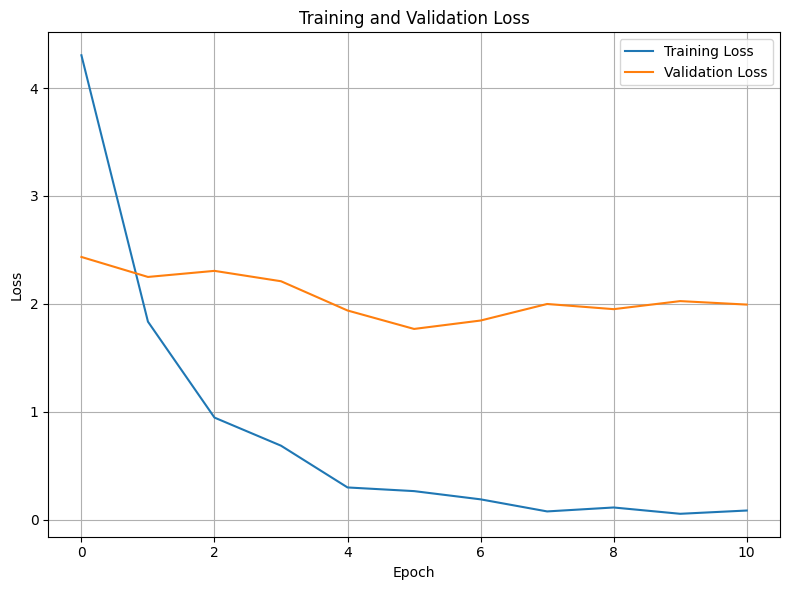

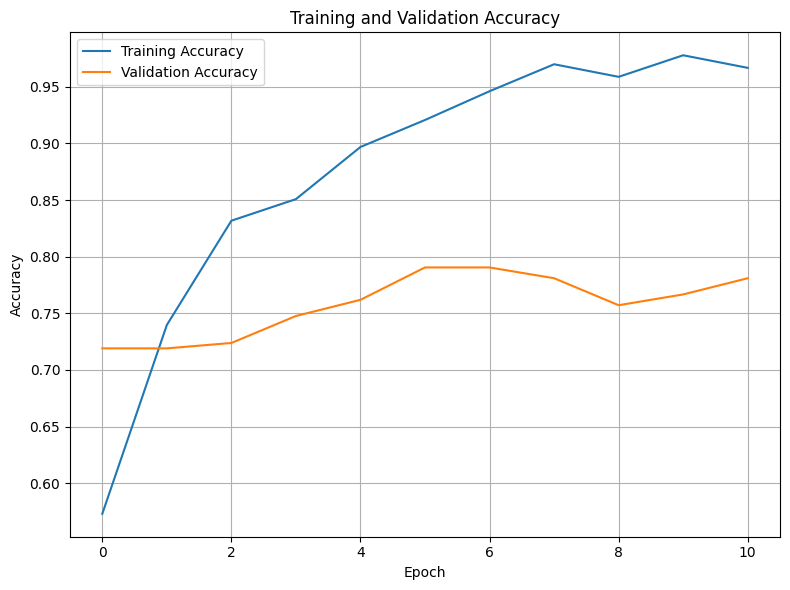

'show_history(history_vgg16_1)\nplot_history(history_vgg16_1, path="standard.png")\nplt.close()'

In [ ]:
plot_loss_accuracy(history_vgg16_1)
"""show_history(history_vgg16_1)
plot_history(history_vgg16_1, path="standard.png")
plt.close()"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'VGG16',
    'Paramètres': "{dropout=0.3, activation='relu', data_aug=False, optimizer='rmsprop'}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_vgg16_1/60
}

# Création du DataFrame à partir du dictionnaire
df_results = pd.DataFrame([data])
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,"[0.9893617, 0.9945946, 0.9944751, 1.0, 1.0, 0....",1.994079,0.780952,0.931684,"[0.74999994, 0.6808511, 0.7368421, 0.74285716,...",1.768461,0.790476,0.935346,"[0.7457627, 0.7083333, 0.76363635, 0.7761194, ...",1.061697,0.842857,0.954881,"[0.7169811, 0.83870965, 0.84210527, 0.8484848,...",89.088674


### Test VGG 19 - sans data augmentation

In [ ]:
model_vgg19_1 = create_model_fct(model_name="VGG19")

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Création du callback
weights_file_name2 = "./model_vgg19_1_best_weights.h5"
model_vgg19_1_save_path = os.path.join(weights_save_path, weights_file_name2)
checkpoint = ModelCheckpoint(model_vgg19_1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_vgg19_1 = model_vgg19_1.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=64, epochs=50, callbacks=callbacks_list, verbose=1)
time_vgg19_1 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 4.7938 - accuracy: 0.5302 - auc: 0.7830 - f1_score: 0.5290 
Epoch 1: val_loss improved from inf to 2.35943, saving model to /content/drive/My Drive/P6/Models/./model_vgg19_1_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 584s 29s/step - loss: 4.7938 - accuracy: 0.5302 - auc: 0.7830 - f1_score: 0.5290 - val_loss: 2.3594 - val_accuracy: 0.6762 - val_auc: 0.8868 - val_f1_score: 0.6832
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.6812 - accuracy: 0.7492 - auc: 0.9194 - f1_score: 0.7498 
Epoch 2: val_loss improved from 2.35943 to 2.08655, saving model to /content/drive/My Drive/P6/Models/./model_vgg19_1_best_weights.h5
20/20 [==============================] - 569s 29s/step - loss: 1.6812 - accuracy: 0.7492 - auc: 0.9194 - f1_score: 0.7498 - val_loss: 2.0865 - val_accuracy: 0.7190 - val_auc: 0.8981 - val_f1_score: 0.7240
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.8942 - accuracy: 0.8000 - auc: 0.9532 - f1_score: 0.8000 
Epoch 3: val_loss improved from 2.08655 to 1.90488, saving model to /content/drive/My Drive/P6/Models/./model_vgg19_1_best_weights.h5
20/20 [==============================] - 570s 29s/step - loss: 0.8

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_vgg19_1.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_vgg19_1.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 426s 21s/step - loss: 0.0033 - accuracy: 1.0000 - auc: 1.0000 - f1_score: 1.0000
Training Accuracy   : 1.0000

7/7 [==============================] - 142s 20s/step - loss: 1.9913 - accuracy: 0.7762 - auc: 0.9169 - f1_score: 0.7728
Validation Accuracy :  0.7762


In [ ]:
# Score de l'epoch optimal

model_vgg19_1.load_weights(model_vgg19_1_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_vgg19_1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_vgg19_1.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.7524
Test Accuracy       :  0.7524


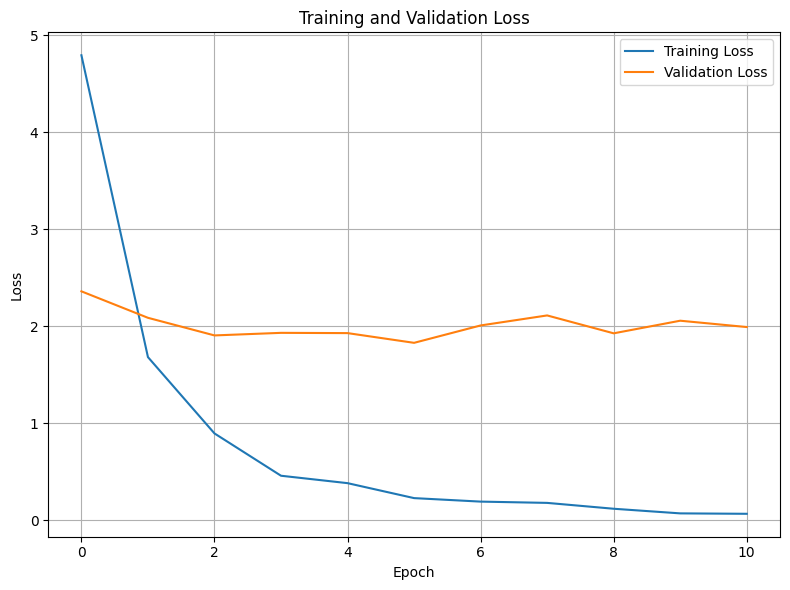

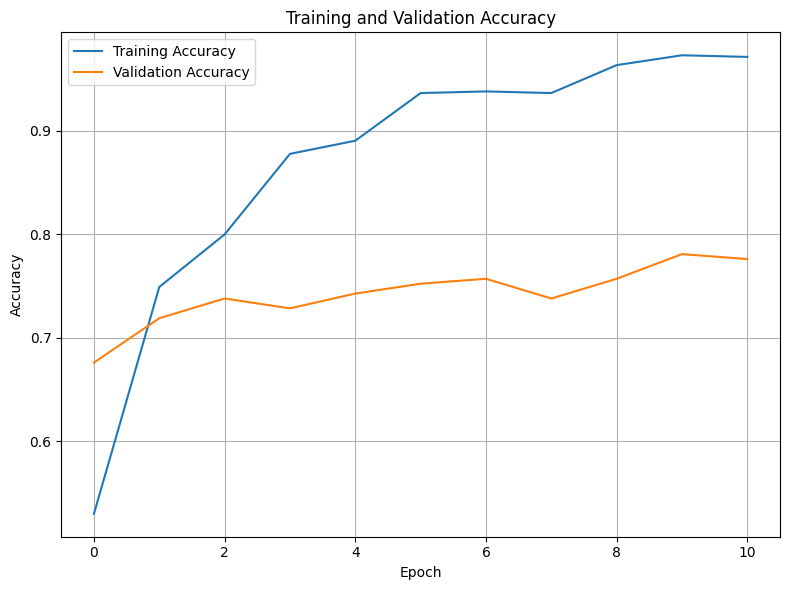

'\nshow_history(history_vgg19_1)\nplot_history(history_vgg19_1, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_vgg19_1)
"""
show_history(history_vgg19_1)
plot_history(history_vgg19_1, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'VGG19',
    'Paramètres': "{dropout=0.3, activation='relu', data_aug=False, optimizer='rmsprop'}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_vgg19_1/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,"[0.9893617, 0.9945946, 0.9944751, 1.0, 1.0, 0....",1.994079,0.780952,0.931684,"[0.74999994, 0.6808511, 0.7368421, 0.74285716,...",1.768461,0.790476,0.935346,"[0.7457627, 0.7083333, 0.76363635, 0.7761194, ...",1.061697,0.842857,0.954881,"[0.7169811, 0.83870965, 0.84210527, 0.8484848,...",89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.991282,0.776190,0.916948,"[0.6875, 0.71111107, 0.80701756, 0.71641797, 0...",1.828464,0.752381,0.913390,"[0.70967746, 0.6415094, 0.7346939, 0.6428572, ...",1.414793,0.752381,0.929862,"[0.53846157, 0.73846155, 0.76470584, 0.7368421...",111.875271


### Test ResNet50 sans data-augmentation :

In [ ]:
model_resnet_1 = create_model_fct(model_name="ResNet50")

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

In [ ]:
# Création du callback
weights_file_name3 = "./model_resnet_1_best_weights.h5"
model_resnet_1_save_path = os.path.join(weights_save_path, weights_file_name3)
checkpoint = ModelCheckpoint(model_resnet_1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_resnet_1 = model_resnet_1.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=64, epochs=50, callbacks=callbacks_list, verbose=1)
time_resnet_1 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.7334 - accuracy: 0.5524 - auc: 0.8347 - f1_score: 0.5518
Epoch 1: val_loss improved from inf to 1.10999, saving model to /content/drive/My Drive/P6/Models/./model_resnet_1_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 166s 8s/step - loss: 1.7334 - accuracy: 0.5524 - auc: 0.8347 - f1_score: 0.5518 - val_loss: 1.1100 - val_accuracy: 0.6619 - val_auc: 0.9064 - val_f1_score: 0.6558
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.8286 - auc: 0.9711 - f1_score: 0.8281
Epoch 2: val_loss did not improve from 1.10999
20/20 [==============================] - 157s 8s/step - loss: 0.5664 - accuracy: 0.8286 - auc: 0.9711 - f1_score: 0.8281 - val_loss: 1.4425 - val_accuracy: 0.5905 - val_auc: 0.8821 - val_f1_score: 0.5946
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.8063 - auc: 0.9693 - f1_score: 0.8058
Epoch 3: val_loss improved from 1.10999 to 0.91157, saving model to /content/drive/My Drive/P6/Models/./model_resnet_1_best_weights.h5
20/20 [==============================] - 159s 8s/step - loss: 0.5794 - accuracy: 0.8063 - auc: 0.9693 - f1_score: 0.8058 - val_loss: 0.9116 - val_accuracy: 

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_resnet_1.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_resnet_1.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 121s 6s/step - loss: 0.0358 - accuracy: 0.9937 - auc: 0.9999 - f1_score: 0.9938
Training Accuracy   : 0.9937

7/7 [==============================] - 41s 5s/step - loss: 1.0956 - accuracy: 0.7476 - auc: 0.9325 - f1_score: 0.7474
Validation Accuracy :  0.7476


In [ ]:
# Score de l'epoch optimal

model_resnet_1.load_weights(model_resnet_1_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_resnet_1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_resnet_1.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.7429
Test Accuracy       :  0.7381


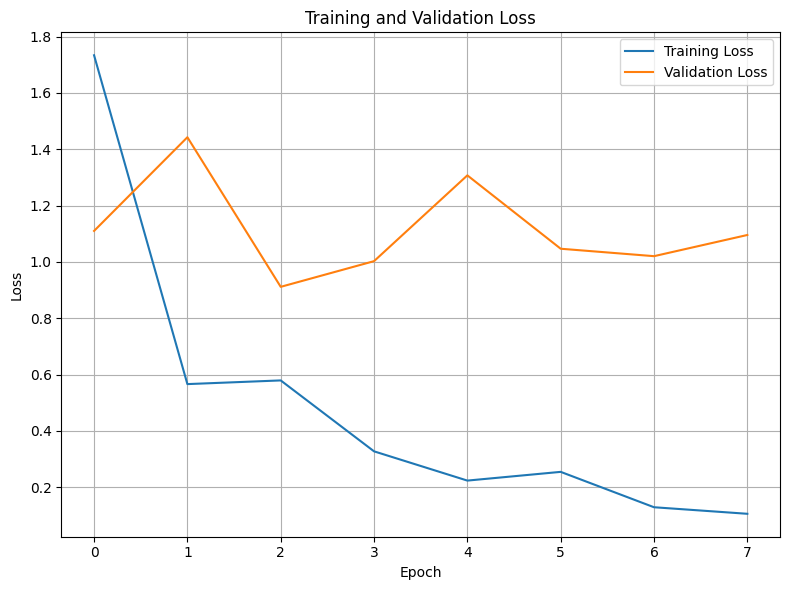

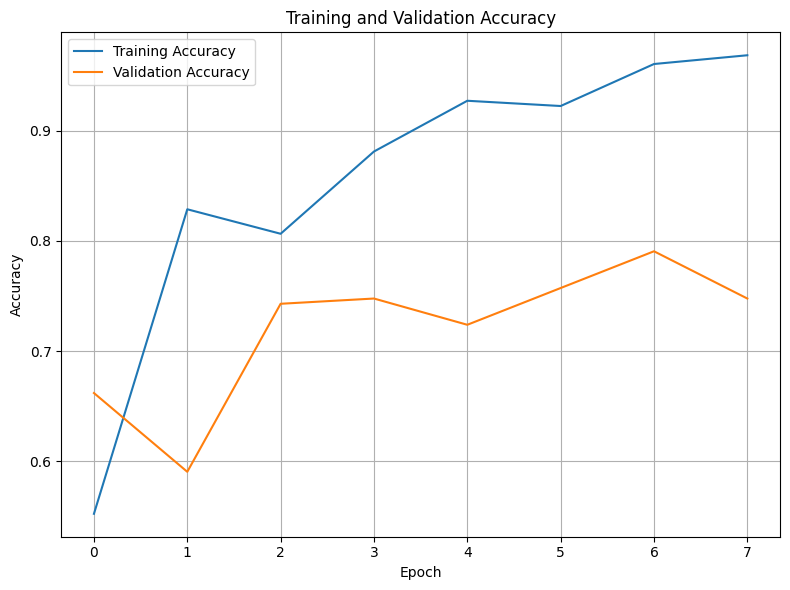

'\nshow_history(history_resnet_1)\nplot_history(history_resnet_1, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_resnet_1)
"""
show_history(history_resnet_1)
plot_history(history_resnet_1, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'ResNet50',
    'Paramètres': "{dropout=0.3, activation='relu', data_aug=False, optimizer='rmsprop'}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_resnet_1/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,"[0.9893617, 0.9945946, 0.9944751, 1.0, 1.0, 0....",1.994079,0.780952,0.931684,"[0.74999994, 0.6808511, 0.7368421, 0.74285716,...",1.768461,0.790476,0.935346,"[0.7457627, 0.7083333, 0.76363635, 0.7761194, ...",1.061697,0.842857,0.954881,"[0.7169811, 0.83870965, 0.84210527, 0.8484848,...",89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.991282,0.776190,0.916948,"[0.6875, 0.71111107, 0.80701756, 0.71641797, 0...",1.828464,0.752381,0.913390,"[0.70967746, 0.6415094, 0.7346939, 0.6428572, ...",1.414793,0.752381,0.929862,"[0.53846157, 0.73846155, 0.76470584, 0.7368421...",111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,"[0.9791667, 1.0, 1.0, 1.0, 0.97727275, 1.0, 1.0]",1.095567,0.747619,0.932487,"[0.6376812, 0.71111107, 0.78260875, 0.75, 0.61...",0.911570,0.742857,0.937600,"[0.631579, 0.64000005, 0.6976744, 0.6896552, 0...",0.875823,0.738095,0.939392,"[0.5428571, 0.8000001, 0.73015875, 0.6909091, ...",22.885804


### Test MobileNet sans data-augmentation :

In [ ]:
model_mobilenet_1 = create_model_fct(model_name="MobileNet")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [ ]:
# Création du callback
weights_file_name4 = "./model_mobilenet_1_best_weights.h5"
model_mobilenet_1_save_path = os.path.join(weights_save_path, weights_file_name4)
checkpoint = ModelCheckpoint(model_mobilenet_1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_mobilenet_1 = model_mobilenet_1.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=64, epochs=50, callbacks=callbacks_list, verbose=1)
time_mobilenet_1 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.1268 - accuracy: 0.3698 - auc: 0.7118 - f1_score: 0.3667
Epoch 1: val_loss improved from inf to 1.33052, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_1_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 57s 3s/step - loss: 2.1268 - accuracy: 0.3698 - auc: 0.7118 - f1_score: 0.3667 - val_loss: 1.3305 - val_accuracy: 0.5429 - val_auc: 0.8439 - val_f1_score: 0.5149
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.1946 - accuracy: 0.5889 - auc: 0.8790 - f1_score: 0.5871
Epoch 2: val_loss improved from 1.33052 to 1.14392, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_1_best_weights.h5
20/20 [==============================] - 54s 3s/step - loss: 1.1946 - accuracy: 0.5889 - auc: 0.8790 - f1_score: 0.5871 - val_loss: 1.1439 - val_accuracy: 0.5905 - val_auc: 0.8864 - val_f1_score: 0.5817
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.9876 - accuracy: 0.6698 - auc: 0.9174 - f1_score: 0.6700
Epoch 3: val_loss did not improve from 1.14392
20/20 [==============================] - 53s 3s/step - loss: 0.9876 - accuracy: 0.6698 - auc: 0.9174 - f1_score: 0.6700 - val_loss: 1.5089 - val_accuracy: 

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_mobilenet_1.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_mobilenet_1.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 33s 1s/step - loss: 0.1684 - accuracy: 0.9587 - auc: 0.9985 - f1_score: 0.9587
Training Accuracy   : 0.9587

7/7 [==============================] - 12s 1s/step - loss: 1.1172 - accuracy: 0.6333 - auc: 0.9143 - f1_score: 0.6249
Validation Accuracy :  0.6333


In [ ]:
# Score de l'epoch optimal

model_mobilenet_1.load_weights(model_mobilenet_1_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_mobilenet_1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_mobilenet_1.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.6476
Test Accuracy       :  0.6571


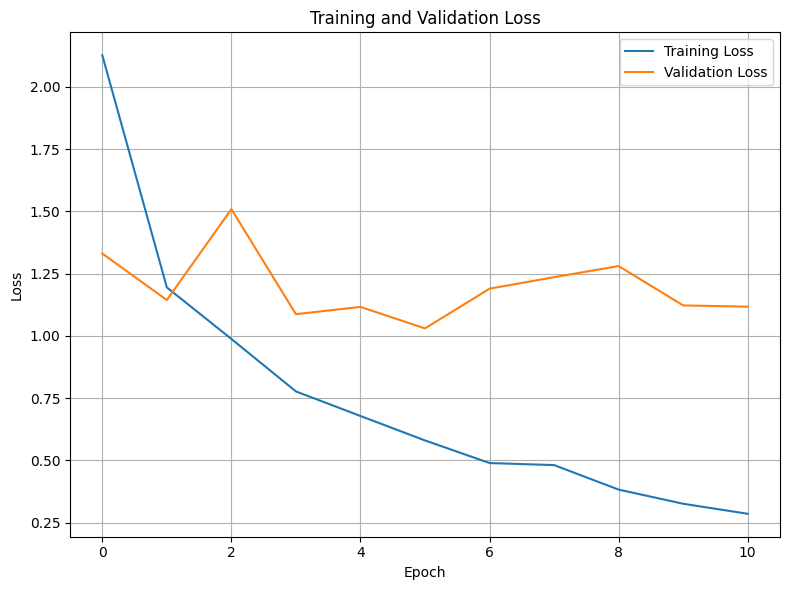

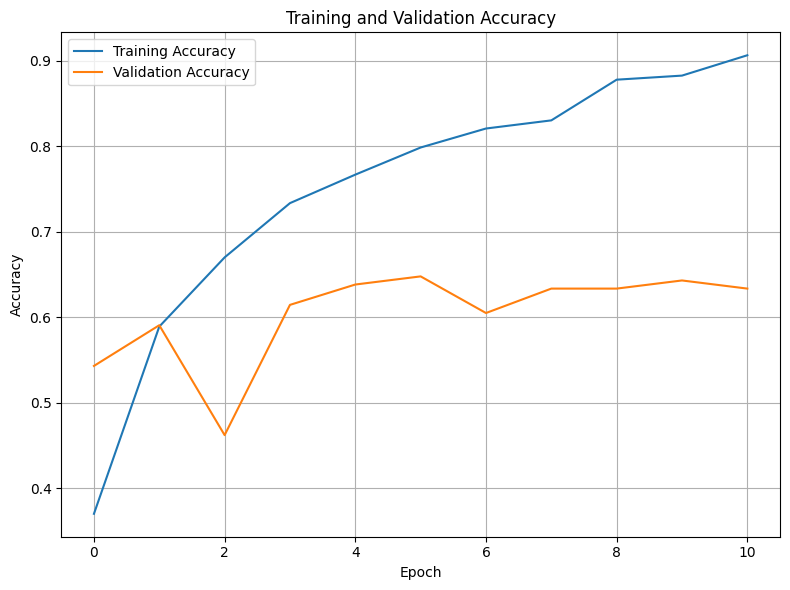

'\nshow_history(history_mobilenet_1)\nplot_history(history_mobilenet_1, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_mobilenet_1)
"""
show_history(history_mobilenet_1)
plot_history(history_mobilenet_1, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'MobileNet',
    'Paramètres': "{dropout=0.3, activation='relu', data_aug=False, optimizer='rmsprop'}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_mobilenet_1/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,"[0.9893617, 0.9945946, 0.9944751, 1.0, 1.0, 0....",1.994079,0.780952,0.931684,"[0.74999994, 0.6808511, 0.7368421, 0.74285716,...",1.768461,0.790476,0.935346,"[0.7457627, 0.7083333, 0.76363635, 0.7761194, ...",1.061697,0.842857,0.954881,"[0.7169811, 0.83870965, 0.84210527, 0.8484848,...",89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.991282,0.776190,0.916948,"[0.6875, 0.71111107, 0.80701756, 0.71641797, 0...",1.828464,0.752381,0.913390,"[0.70967746, 0.6415094, 0.7346939, 0.6428572, ...",1.414793,0.752381,0.929862,"[0.53846157, 0.73846155, 0.76470584, 0.7368421...",111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,"[0.9791667, 1.0, 1.0, 1.0, 0.97727275, 1.0, 1.0]",1.095567,0.747619,0.932487,"[0.6376812, 0.71111107, 0.78260875, 0.75, 0.61...",0.911570,0.742857,0.937600,"[0.631579, 0.64000005, 0.6976744, 0.6896552, 0...",0.875823,0.738095,0.939392,"[0.5428571, 0.8000001, 0.73015875, 0.6909091, ...",22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,"[0.9473684, 0.9523809, 0.97727275, 0.94545454,...",1.117236,0.633333,0.914269,"[0.5806452, 0.45901644, 0.6363636, 0.5882353, ...",1.029917,0.647619,0.914050,"[0.5806452, 0.5333333, 0.6666667, 0.64516133, ...",0.941683,0.657143,0.928804,"[0.5714286, 0.64864874, 0.65625006, 0.5263158,...",12.106025


### Les meilleurs résultats sont obtenus avec les modèles VGG16 et VGG 19, cependant leur temps d'entrainement est nettement supérieur. Je tente d'entraîner de nouveaux modèles à partir de ResNet50 et MobileNet en changeant quelques paramètres

### Test ResNet50 avec dropout à 0.2 et activation 'tanh

In [ ]:
model_resnet_2 = create_model_fct(model_name="ResNet50", dropout_rate = 0.2, activation = "tanh")

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
# Création du callback
weights_file_name5 = "./model_resnet_1_best_weights.h5"
model_resnet_2_save_path = os.path.join(weights_save_path, weights_file_name5)
checkpoint = ModelCheckpoint(model_resnet_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_resnet_2 = model_resnet_2.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=64, epochs=50, callbacks=callbacks_list, verbose=1)
time_resnet_2 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.4109 - accuracy: 0.6254 - auc: 0.8709 - f1_score: 0.6250
Epoch 1: val_loss improved from inf to 0.99189, saving model to /content/drive/My Drive/P6/Models/./model_resnet_1_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 169s 8s/step - loss: 1.4109 - accuracy: 0.6254 - auc: 0.8709 - f1_score: 0.6250 - val_loss: 0.9919 - val_accuracy: 0.6524 - val_auc: 0.9214 - val_f1_score: 0.6435
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.8159 - auc: 0.9730 - f1_score: 0.8153
Epoch 2: val_loss improved from 0.99189 to 0.85232, saving model to /content/drive/My Drive/P6/Models/./model_resnet_1_best_weights.h5
20/20 [==============================] - 173s 9s/step - loss: 0.5430 - accuracy: 0.8159 - auc: 0.9730 - f1_score: 0.8153 - val_loss: 0.8523 - val_accuracy: 0.7286 - val_auc: 0.9400 - val_f1_score: 0.7260
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8810 - auc: 0.9869 - f1_score: 0.8812
Epoch 3: val_loss did not improve from 0.85232
20/20 [==============================] - 162s 8s/step - loss: 0.3597 - accuracy: 0.8810 - auc: 0.9869 - f1_score: 0.8812 - val_loss: 1.0172 - val_accuracy: 

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_resnet_2.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_resnet_2.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 121s 6s/step - loss: 0.0449 - accuracy: 0.9952 - auc: 0.9999 - f1_score: 0.9953
Training Accuracy   : 0.9952

7/7 [==============================] - 40s 5s/step - loss: 1.0638 - accuracy: 0.7238 - auc: 0.9357 - f1_score: 0.7291
Validation Accuracy :  0.7238


In [ ]:
# Score de l'epoch optimal

model_resnet_2.load_weights(model_resnet_2_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_resnet_2.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_resnet_2.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.7286
Test Accuracy       :  0.7667


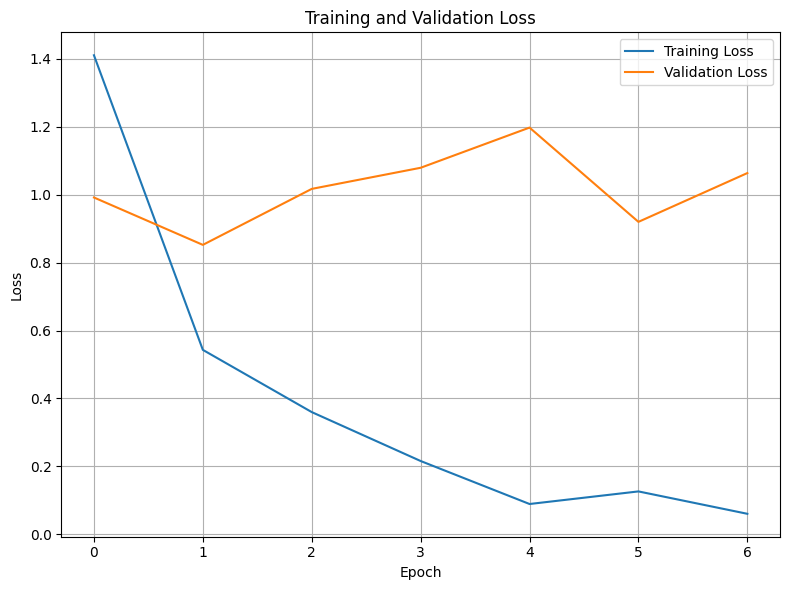

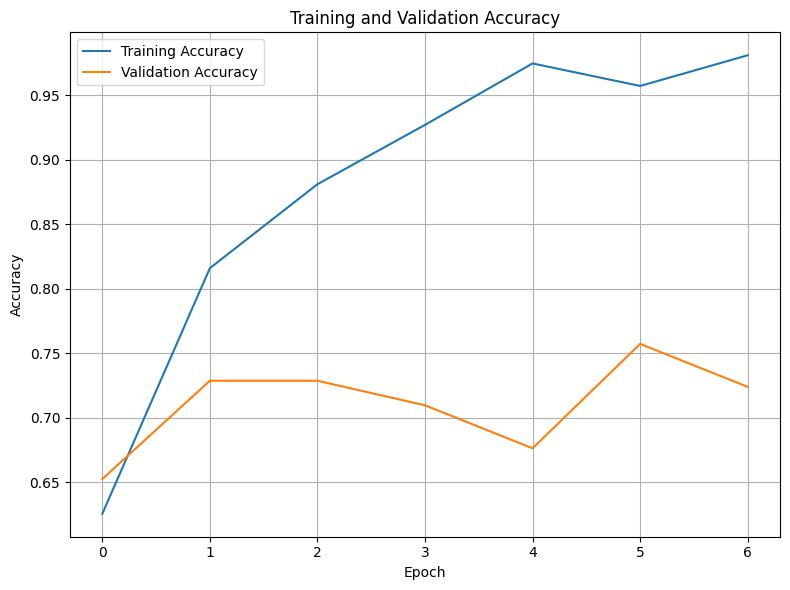

'\nshow_history(history_resnet_2)\nplot_history(history_resnet_2, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_resnet_2)
"""
show_history(history_resnet_2)
plot_history(history_resnet_2, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'ResNet50',
    'Paramètres': "{dropout=0.2, activation='tanh', data_aug=False, optimizer='rmsprop', batch=32}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_resnet_2/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,"[0.9893617, 0.9945946, 0.9944751, 1.0, 1.0, 0....",1.994079,0.780952,0.931684,"[0.74999994, 0.6808511, 0.7368421, 0.74285716,...",1.768461,0.790476,0.935346,"[0.7457627, 0.7083333, 0.76363635, 0.7761194, ...",1.061697,0.842857,0.954881,"[0.7169811, 0.83870965, 0.84210527, 0.8484848,...",89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.991282,0.776190,0.916948,"[0.6875, 0.71111107, 0.80701756, 0.71641797, 0...",1.828464,0.752381,0.913390,"[0.70967746, 0.6415094, 0.7346939, 0.6428572, ...",1.414793,0.752381,0.929862,"[0.53846157, 0.73846155, 0.76470584, 0.7368421...",111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,"[0.9791667, 1.0, 1.0, 1.0, 0.97727275, 1.0, 1.0]",1.095567,0.747619,0.932487,"[0.6376812, 0.71111107, 0.78260875, 0.75, 0.61...",0.911570,0.742857,0.937600,"[0.631579, 0.64000005, 0.6976744, 0.6896552, 0...",0.875823,0.738095,0.939392,"[0.5428571, 0.8000001, 0.73015875, 0.6909091, ...",22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,"[0.9473684, 0.9523809, 0.97727275, 0.94545454,...",1.117236,0.633333,0.914269,"[0.5806452, 0.45901644, 0.6363636, 0.5882353, ...",1.029917,0.647619,0.914050,"[0.5806452, 0.5333333, 0.6666667, 0.64516133, ...",0.941683,0.657143,0.928804,"[0.5714286, 0.64864874, 0.65625006, 0.5263158,...",12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,"[0.9842932, 0.9945355, 0.9944134, 1.0, 1.0, 0....",1.063808,0.723810,0.935739,"[0.5432099, 0.6666667, 0.7111111, 0.7096774, 0...",0.852322,0.728571,0.940032,"[0.5714286, 0.6818182, 0.6818182, 0.73239434, ...",0.813758,0.766667,0.946053,"[0.6451613, 0.8474576, 0.7462687, 0.7076923, 0...",20.438973


### Test MobileNet avec dropout = 0.5, activation = 'relu', optimizer= 'adam' et batch = 16

In [ ]:
model_mobilenet_2 = create_model_fct(model_name="MobileNet", dropout_rate = 0.5, activation = 'relu', optimizer="adam")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [ ]:
# Création du callback
weights_file_name6 = "./model_mobilenet_2_best_weights.h5"
model_mobilenet_2_save_path = os.path.join(weights_save_path, weights_file_name6)
checkpoint = ModelCheckpoint(model_mobilenet_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_mobilenet_2 = model_mobilenet_2.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=16, epochs=50, callbacks=callbacks_list, verbose=1)
time_mobilenet_2 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.0549 - accuracy: 0.3175 - auc: 0.6620 - f1_score: 0.3150
Epoch 1: val_loss improved from inf to 1.35297, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_2_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 60s 3s/step - loss: 2.0549 - accuracy: 0.3175 - auc: 0.6620 - f1_score: 0.3150 - val_loss: 1.3530 - val_accuracy: 0.4667 - val_auc: 0.8509 - val_f1_score: 0.4621
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.2007 - accuracy: 0.5746 - auc: 0.8756 - f1_score: 0.5739
Epoch 2: val_loss improved from 1.35297 to 1.16286, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_2_best_weights.h5
20/20 [==============================] - 55s 3s/step - loss: 1.2007 - accuracy: 0.5746 - auc: 0.8756 - f1_score: 0.5739 - val_loss: 1.1629 - val_accuracy: 0.5857 - val_auc: 0.8855 - val_f1_score: 0.5788
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.9685 - accuracy: 0.6794 - auc: 0.9210 - f1_score: 0.6789
Epoch 3: val_loss improved from 1.16286 to 1.09451, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_2_best_weights.h5
20/20 [==============================] - 46s 2s/step - loss: 0.9

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_mobilenet_2.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_mobilenet_2.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 33s 1s/step - loss: 0.1397 - accuracy: 0.9857 - auc: 0.9994 - f1_score: 0.9859
Training Accuracy   : 0.9857

7/7 [==============================] - 11s 1s/step - loss: 0.9820 - accuracy: 0.6952 - auc: 0.9259 - f1_score: 0.6900
Validation Accuracy :  0.6952


In [ ]:
# Score de l'epoch optimal

model_mobilenet_2.load_weights(model_mobilenet_2_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_mobilenet_2.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_mobilenet_2.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.7000
Test Accuracy       :  0.6762


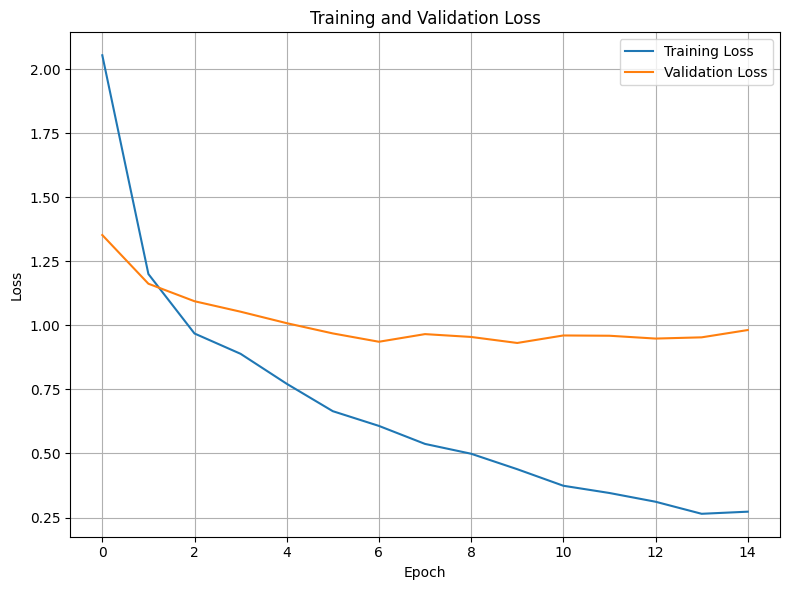

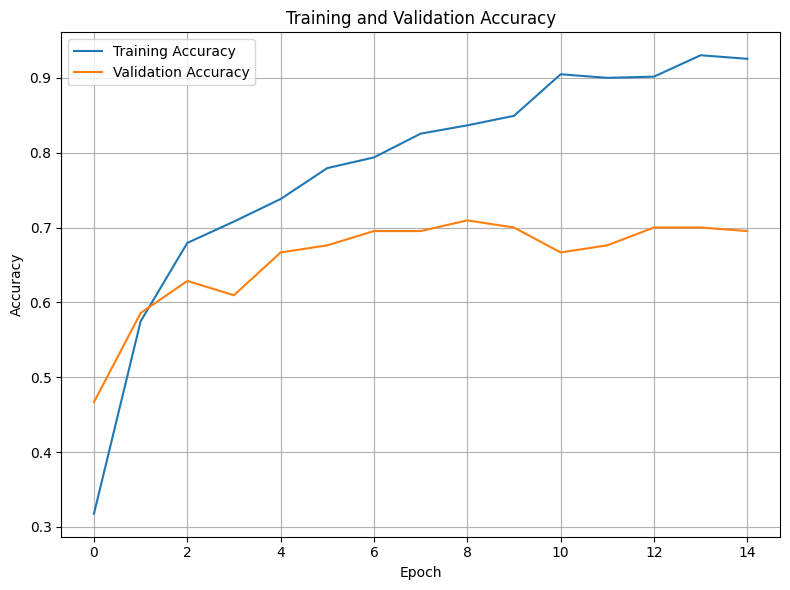

'\nshow_history(history_mobilenet_2)\nplot_history(history_mobilenet_2, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_mobilenet_2)
"""
show_history(history_mobilenet_2)
plot_history(history_mobilenet_2, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'MobileNet',
    'Paramètres': "{dropout=0.5, activation='relu', data_aug=False, optimizer='adam', batch=16}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_mobilenet_2/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,"[0.9893617, 0.9945946, 0.9944751, 1.0, 1.0, 0....",1.994079,0.780952,0.931684,"[0.74999994, 0.6808511, 0.7368421, 0.74285716,...",1.768461,0.790476,0.935346,"[0.7457627, 0.7083333, 0.76363635, 0.7761194, ...",1.061697,0.842857,0.954881,"[0.7169811, 0.83870965, 0.84210527, 0.8484848,...",89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.991282,0.776190,0.916948,"[0.6875, 0.71111107, 0.80701756, 0.71641797, 0...",1.828464,0.752381,0.913390,"[0.70967746, 0.6415094, 0.7346939, 0.6428572, ...",1.414793,0.752381,0.929862,"[0.53846157, 0.73846155, 0.76470584, 0.7368421...",111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,"[0.9791667, 1.0, 1.0, 1.0, 0.97727275, 1.0, 1.0]",1.095567,0.747619,0.932487,"[0.6376812, 0.71111107, 0.78260875, 0.75, 0.61...",0.911570,0.742857,0.937600,"[0.631579, 0.64000005, 0.6976744, 0.6896552, 0...",0.875823,0.738095,0.939392,"[0.5428571, 0.8000001, 0.73015875, 0.6909091, ...",22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,"[0.9473684, 0.9523809, 0.97727275, 0.94545454,...",1.117236,0.633333,0.914269,"[0.5806452, 0.45901644, 0.6363636, 0.5882353, ...",1.029917,0.647619,0.914050,"[0.5806452, 0.5333333, 0.6666667, 0.64516133, ...",0.941683,0.657143,0.928804,"[0.5714286, 0.64864874, 0.65625006, 0.5263158,...",12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,"[0.9842932, 0.9945355, 0.9944134, 1.0, 1.0, 0....",1.063808,0.723810,0.935739,"[0.5432099, 0.6666667, 0.7111111, 0.7096774, 0...",0.852322,0.728571,0.940032,"[0.5714286, 0.6818182, 0.6818182, 0.73239434, ...",0.813758,0.766667,0.946053,"[0.6451613, 0.8474576, 0.7462687, 0.7076923, 0...",20.438973
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.139652,0.985714,0.999428,"[0.97382194, 0.9836066, 0.9944134, 0.99421966,...",0.981981,0.695238,0.925882,"[0.5, 0.54999995, 0.6818182, 0.7540984, 0.7058...",0.931535,0.700000,0.927819,"[0.54545456, 0.52380955, 0.68085104, 0.6956522...",0.880991,0.676190,0.934197,"[0.43137255, 0.69696975, 0.67647064, 0.6071428...",18.402466


Les résultats de MobileNet avec ces nouveaux paramètres ne sont pas concluant non plus.

### Test MobileNet avec dropout = 0.5, activation = 'tanh', optimizer= 'adam' et batch = 32

In [ ]:
model_mobilenet_3 = create_model_fct(model_name="MobileNet", dropout_rate = 0.5, activation = 'tanh', optimizer="adam")

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [ ]:
# Création du callback
weights_file_name7 = "./model_mobilenet_3_best_weights.h5"
model_mobilenet_3_save_path = os.path.join(weights_save_path, weights_file_name7)
checkpoint = ModelCheckpoint(model_mobilenet_3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_mobilenet_3 = model_mobilenet_3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=32, epochs=50, callbacks=callbacks_list, verbose=1)
time_mobilenet_3 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.9906 - accuracy: 0.3079 - auc: 0.6943 - f1_score: 0.3059
Epoch 1: val_loss improved from inf to 1.21487, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_3_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 49s 2s/step - loss: 1.9906 - accuracy: 0.3079 - auc: 0.6943 - f1_score: 0.3059 - val_loss: 1.2149 - val_accuracy: 0.5714 - val_auc: 0.8725 - val_f1_score: 0.5628
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.2430 - accuracy: 0.5667 - auc: 0.8762 - f1_score: 0.5647
Epoch 2: val_loss improved from 1.21487 to 1.16687, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_3_best_weights.h5
20/20 [==============================] - 54s 3s/step - loss: 1.2430 - accuracy: 0.5667 - auc: 0.8762 - f1_score: 0.5647 - val_loss: 1.1669 - val_accuracy: 0.5714 - val_auc: 0.8873 - val_f1_score: 0.5601
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.9935 - accuracy: 0.6714 - auc: 0.9189 - f1_score: 0.6719
Epoch 3: val_loss improved from 1.16687 to 1.11599, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_3_best_weights.h5
20/20 [==============================] - 54s 3s/step - loss: 0.9

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_mobilenet_3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_mobilenet_3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 34s 1s/step - loss: 0.2312 - accuracy: 0.9397 - auc: 0.9972 - f1_score: 0.9398
Training Accuracy   : 0.9397

7/7 [==============================] - 12s 1s/step - loss: 0.9608 - accuracy: 0.6905 - auc: 0.9283 - f1_score: 0.6806
Validation Accuracy :  0.6905


In [ ]:
# Score de l'epoch optimal

model_mobilenet_3.load_weights(model_mobilenet_3_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_mobilenet_3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_mobilenet_3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.6810
Test Accuracy       :  0.6667


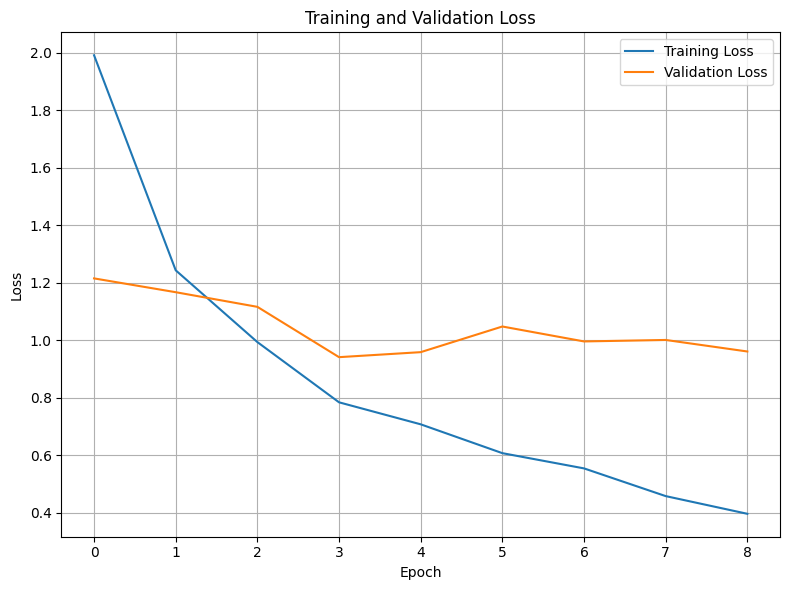

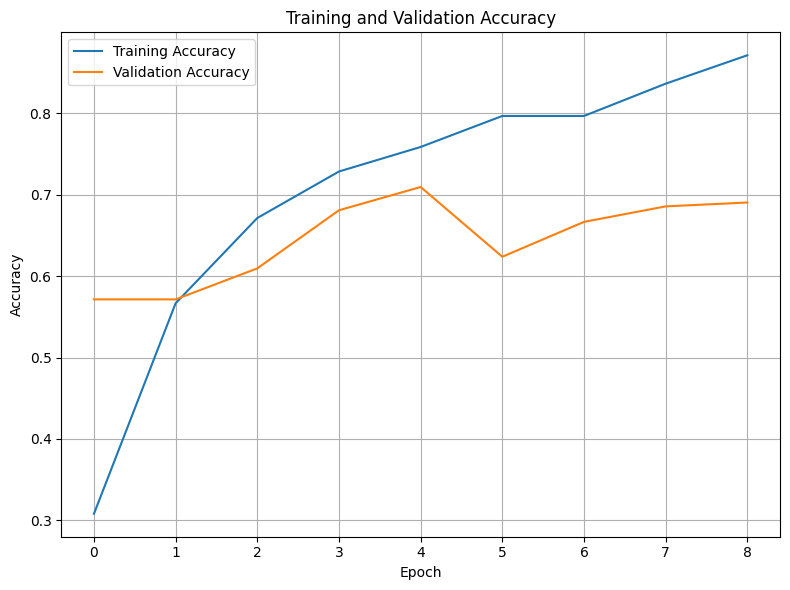

'\nshow_history(history_mobilenet_2)\nplot_history(history_mobilenet_2, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_mobilenet_3)
"""
show_history(history_mobilenet_2)
plot_history(history_mobilenet_2, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'MobileNet',
    'Paramètres': "{dropout=0.5, activation='tanh', data_aug=False, optimizer='adam', batch=32}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_mobilenet_3/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,"[0.9893617, 0.9945946, 0.9944751, 1.0, 1.0, 0....",1.994079,0.780952,0.931684,"[0.74999994, 0.6808511, 0.7368421, 0.74285716,...",1.768461,0.790476,0.935346,"[0.7457627, 0.7083333, 0.76363635, 0.7761194, ...",1.061697,0.842857,0.954881,"[0.7169811, 0.83870965, 0.84210527, 0.8484848,...",89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.991282,0.776190,0.916948,"[0.6875, 0.71111107, 0.80701756, 0.71641797, 0...",1.828464,0.752381,0.913390,"[0.70967746, 0.6415094, 0.7346939, 0.6428572, ...",1.414793,0.752381,0.929862,"[0.53846157, 0.73846155, 0.76470584, 0.7368421...",111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,"[0.9791667, 1.0, 1.0, 1.0, 0.97727275, 1.0, 1.0]",1.095567,0.747619,0.932487,"[0.6376812, 0.71111107, 0.78260875, 0.75, 0.61...",0.911570,0.742857,0.937600,"[0.631579, 0.64000005, 0.6976744, 0.6896552, 0...",0.875823,0.738095,0.939392,"[0.5428571, 0.8000001, 0.73015875, 0.6909091, ...",22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,"[0.9473684, 0.9523809, 0.97727275, 0.94545454,...",1.117236,0.633333,0.914269,"[0.5806452, 0.45901644, 0.6363636, 0.5882353, ...",1.029917,0.647619,0.914050,"[0.5806452, 0.5333333, 0.6666667, 0.64516133, ...",0.941683,0.657143,0.928804,"[0.5714286, 0.64864874, 0.65625006, 0.5263158,...",12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,"[0.9842932, 0.9945355, 0.9944134, 1.0, 1.0, 0....",1.063808,0.723810,0.935739,"[0.5432099, 0.6666667, 0.7111111, 0.7096774, 0...",0.852322,0.728571,0.940032,"[0.5714286, 0.6818182, 0.6818182, 0.73239434, ...",0.813758,0.766667,0.946053,"[0.6451613, 0.8474576, 0.7462687, 0.7076923, 0...",20.438973
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.139652,0.985714,0.999428,"[0.97382194, 0.9836066, 0.9944134, 0.99421966,...",0.981981,0.695238,0.925882,"[0.5, 0.54999995, 0.6818182, 0.7540984, 0.7058...",0.931535,0.700000,0.927819,"[0.54545456, 0.52380955, 0.68085104, 0.6956522...",0.880991,0.676190,0.934197,"[0.43137255, 0.69696975, 0.67647064, 0.6071428...",18.402466
6,MobileNet,"{dropout=0.5, activation='tanh', data_aug=Fals...",0.231202,0.939683,0.997186,"[0.8876405, 0.9137056, 0.960452, 0.954023, 0.9...",0.960776,0.690476,0.928309,"[0.5555555, 0.5423729, 0.6530613, 0.7647059, 0...",0.941069,0.680952,0.924864,"[0.57627124, 0.49122807, 0.6666667, 0.6875, 0....",0.880369,0.666667,0.936395,"[0.54545456, 0.6666666, 0.6349206, 0.55737704,...",10.049382


## Inclusion de data augmentation

On montre rapidement en quoi cela consiste et de quelle manière on va utiliser cette méthode ici.

In [ ]:
path_dataaug = "/content/drive/My Drive/P6/Images/"

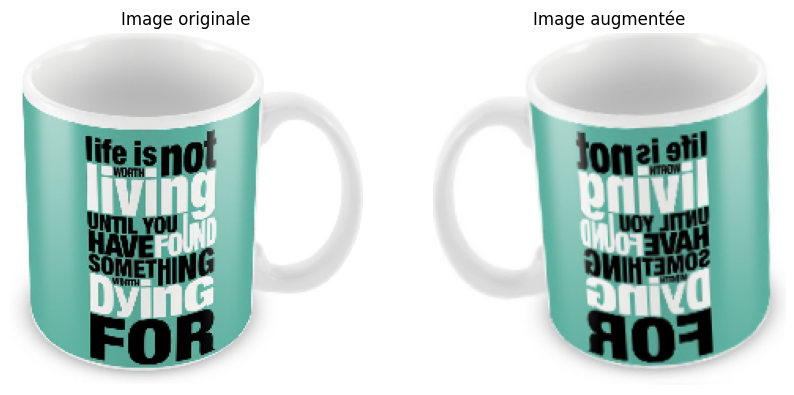

In [ ]:
# Visualisation sur une image des transformations appliquées :

# Charger une image à partir d'un fichier
image_path = os.path.join(path_dataaug, list_photos[0])
image = load_img(image_path, target_size=(224, 224))

# Convertir l'image en tableau numpy
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)  # Ajouter une dimension de lot (batch dimension)

# Définir les paramètres de la data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(224, 224, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
    # Rescaling(1./127.5, offset=-1.0)
])

# Appliquer la data augmentation à l'image
augmented_image = data_augmentation(image_array)

# Convertir l'image augmentée en format compatible avec matplotlib
augmented_image = np.array(augmented_image[0], dtype=np.uint8)

# Afficher l'image originale et l'image augmentée
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image originale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title("Image augmentée")
plt.axis("off")

plt.show()

### Test Resnet50 avec les paramètres suivants : droput=0.2, activation='tanh' et optimizer='rmsprop' avec data augmentation

In [ ]:
model_resnet_3 = create_model_fct(model_name="ResNet50", dropout_rate = 0.2, activation = "tanh", data_aug=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
# Création du callback
weights_file_name8 = "./model_resnet_3_best_weights.h5"
model_resnet_3_save_path = os.path.join(weights_save_path, weights_file_name8)
checkpoint = ModelCheckpoint(model_resnet_3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_resnet_3 = model_resnet_3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=64, epochs=50, callbacks=callbacks_list, verbose=1)
time_resnet_3 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 2.2545 - accuracy: 0.2540 - auc: 0.6152 - f1_score: 0.2501
Epoch 1: val_loss improved from inf to 1.81297, saving model to /content/drive/My Drive/P6/Models/./model_resnet_3_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 177s 8s/step - loss: 2.2545 - accuracy: 0.2540 - auc: 0.6152 - f1_score: 0.2501 - val_loss: 1.8130 - val_accuracy: 0.2619 - val_auc: 0.6832 - val_f1_score: 0.2130
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.8159 - accuracy: 0.3444 - auc: 0.7003 - f1_score: 0.3408
Epoch 2: val_loss did not improve from 1.81297
20/20 [==============================] - 166s 8s/step - loss: 1.8159 - accuracy: 0.3444 - auc: 0.7003 - f1_score: 0.3408 - val_loss: 2.0510 - val_accuracy: 0.3048 - val_auc: 0.6731 - val_f1_score: 0.2550
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.7555 - accuracy: 0.3413 - auc: 0.7242 - f1_score: 0.3381
Epoch 3: val_loss improved from 1.81297 to 1.66695, saving model to /content/drive/My Drive/P6/Models/./model_resnet_3_best_weights.h5
20/20 [==============================] - 167s 8s/step - loss: 1.7555 - accuracy: 0.3413 - auc: 0.7242 - f1_score: 0.3381 - val_loss: 1.6670 - val_accuracy: 

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_resnet_3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_resnet_3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 119s 6s/step - loss: 1.4434 - accuracy: 0.4635 - auc: 0.8159 - f1_score: 0.4319
Training Accuracy   : 0.4635

7/7 [==============================] - 39s 5s/step - loss: 1.7075 - accuracy: 0.3714 - auc: 0.7498 - f1_score: 0.3504
Validation Accuracy :  0.3714


In [ ]:
# Score de l'epoch optimal

model_resnet_3.load_weights(model_resnet_3_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_resnet_3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_resnet_3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.3905
Test Accuracy       :  0.4238


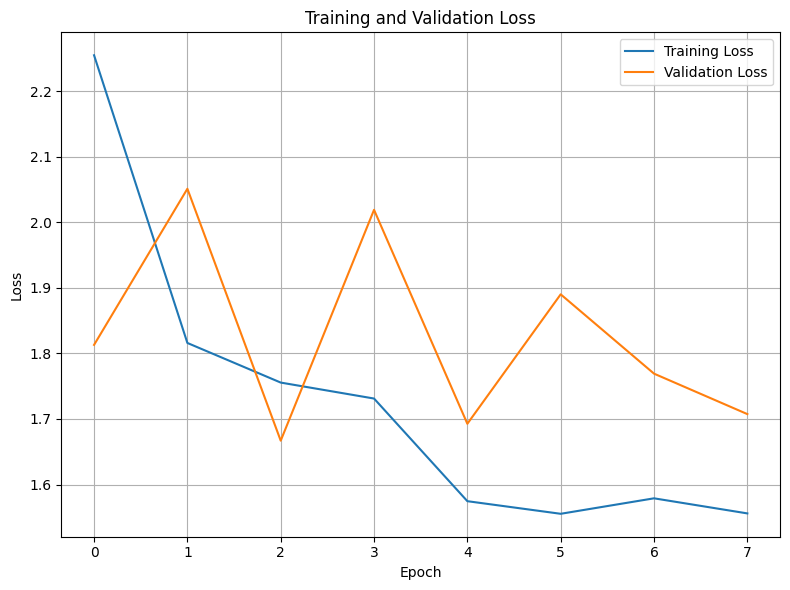

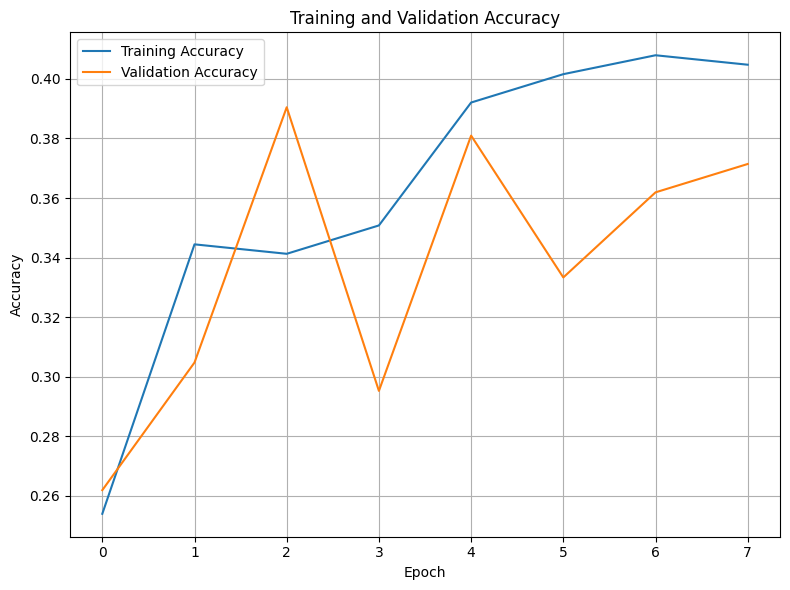

'\nshow_history(history_resnet_3)\nplot_history(history_resnet_3, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_resnet_3)
"""
show_history(history_resnet_3)
plot_history(history_resnet_3, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'ResNet50',
    'Paramètres': "{dropout=0.2, activation='tanh', data_aug=True, optimizer='rmsprop', batch=64}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_resnet_3/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,"[0.9893617, 0.9945946, 0.9944751, 1.0, 1.0, 0....",1.994079,0.780952,0.931684,"[0.74999994, 0.6808511, 0.7368421, 0.74285716,...",1.768461,0.790476,0.935346,"[0.7457627, 0.7083333, 0.76363635, 0.7761194, ...",1.061697,0.842857,0.954881,"[0.7169811, 0.83870965, 0.84210527, 0.8484848,...",89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.991282,0.776190,0.916948,"[0.6875, 0.71111107, 0.80701756, 0.71641797, 0...",1.828464,0.752381,0.913390,"[0.70967746, 0.6415094, 0.7346939, 0.6428572, ...",1.414793,0.752381,0.929862,"[0.53846157, 0.73846155, 0.76470584, 0.7368421...",111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,"[0.9791667, 1.0, 1.0, 1.0, 0.97727275, 1.0, 1.0]",1.095567,0.747619,0.932487,"[0.6376812, 0.71111107, 0.78260875, 0.75, 0.61...",0.911570,0.742857,0.937600,"[0.631579, 0.64000005, 0.6976744, 0.6896552, 0...",0.875823,0.738095,0.939392,"[0.5428571, 0.8000001, 0.73015875, 0.6909091, ...",22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,"[0.9473684, 0.9523809, 0.97727275, 0.94545454,...",1.117236,0.633333,0.914269,"[0.5806452, 0.45901644, 0.6363636, 0.5882353, ...",1.029917,0.647619,0.914050,"[0.5806452, 0.5333333, 0.6666667, 0.64516133, ...",0.941683,0.657143,0.928804,"[0.5714286, 0.64864874, 0.65625006, 0.5263158,...",12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,"[0.9842932, 0.9945355, 0.9944134, 1.0, 1.0, 0....",1.063808,0.723810,0.935739,"[0.5432099, 0.6666667, 0.7111111, 0.7096774, 0...",0.852322,0.728571,0.940032,"[0.5714286, 0.6818182, 0.6818182, 0.73239434, ...",0.813758,0.766667,0.946053,"[0.6451613, 0.8474576, 0.7462687, 0.7076923, 0...",20.438973
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.139652,0.985714,0.999428,"[0.97382194, 0.9836066, 0.9944134, 0.99421966,...",0.981981,0.695238,0.925882,"[0.5, 0.54999995, 0.6818182, 0.7540984, 0.7058...",0.931535,0.700000,0.927819,"[0.54545456, 0.52380955, 0.68085104, 0.6956522...",0.880991,0.676190,0.934197,"[0.43137255, 0.69696975, 0.67647064, 0.6071428...",18.402466
6,MobileNet,"{dropout=0.5, activation='tanh', data_aug=Fals...",0.231202,0.939683,0.997186,"[0.8876405, 0.9137056, 0.960452, 0.954023, 0.9...",0.960776,0.690476,0.928309,"[0.5555555, 0.5423729, 0.6530613, 0.7647059, 0...",0.941069,0.680952,0.924864,"[0.57627124, 0.49122807, 0.6666667, 0.6875, 0....",0.880369,0.666667,0.936395,"[0.54545456, 0.6666666, 0.6349206, 0.55737704,...",10.049382
7,ResNet50,"{dropout=0.2, activation='tanh', data_aug=True...",1.443429,0.463492,0.815946,"[0.37320575, 0.562212, 0.3893805, 0.48000002, ...",1.707465,0.371429,0.749815,"[0.28169015, 0.47619048, 0.38709676, 0.3564357...",1.666951,0.390476,0.746043,"[0.27118647, 0.43902442, 0.375, 0.24390244, 0....",1.655338,0.423810,0.755472,"[0.3272727, 0.5283019, 0.6666667, 0.29787233, ...",24.516449


Les résultats ne sont clairement pas bons.

### Test MobileNet avec data-augmentation

In [ ]:
model_mobilenet_4 = create_model_fct(model_name="MobileNet", dropout_rate = 0.5, activation = "tanh", data_aug=True, optimizer='adam')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_9  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 256)               262400    
                                                                 
 dropout_9 (Dropout)         (None, 256)              

In [ ]:
# Création du callback
weights_file_name9 = "./model_mobilenet_4_best_weights.h5"
model_mobilenet_4_save_path = os.path.join(weights_save_path, weights_file_name9)
checkpoint = ModelCheckpoint(model_mobilenet_4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_mobilenet_4 = model_mobilenet_4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=32, epochs=50, callbacks=callbacks_list, verbose=1)
time_mobilenet_4 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.4396 - accuracy: 0.4984 - auc: 0.8342 - f1_score: 0.4978
Epoch 1: val_loss improved from inf to 0.72780, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_4_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 56s 2s/step - loss: 1.4396 - accuracy: 0.4984 - auc: 0.8342 - f1_score: 0.4978 - val_loss: 0.7278 - val_accuracy: 0.7667 - val_auc: 0.9510 - val_f1_score: 0.7601
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.7431 - accuracy: 0.7635 - auc: 0.9513 - f1_score: 0.7631
Epoch 2: val_loss improved from 0.72780 to 0.67618, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_4_best_weights.h5
20/20 [==============================] - 61s 3s/step - loss: 0.7431 - accuracy: 0.7635 - auc: 0.9513 - f1_score: 0.7631 - val_loss: 0.6762 - val_accuracy: 0.7762 - val_auc: 0.9610 - val_f1_score: 0.7711
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.8111 - auc: 0.9728 - f1_score: 0.8120
Epoch 3: val_loss improved from 0.67618 to 0.63505, saving model to /content/drive/My Drive/P6/Models/./model_mobilenet_4_best_weights.h5
20/20 [==============================] - 59s 3s/step - loss: 0.5

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_mobilenet_4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_mobilenet_4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 33s 1s/step - loss: 0.1291 - accuracy: 0.9635 - auc: 0.9980 - f1_score: 0.9634
Training Accuracy   : 0.9635

7/7 [==============================] - 11s 1s/step - loss: 0.6690 - accuracy: 0.8000 - auc: 0.9576 - f1_score: 0.7941
Validation Accuracy :  0.8000


In [ ]:
# Score de l'epoch optimal

model_mobilenet_4.load_weights(model_mobilenet_4_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_mobilenet_4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_mobilenet_4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.7857
Test Accuracy       :  0.8381


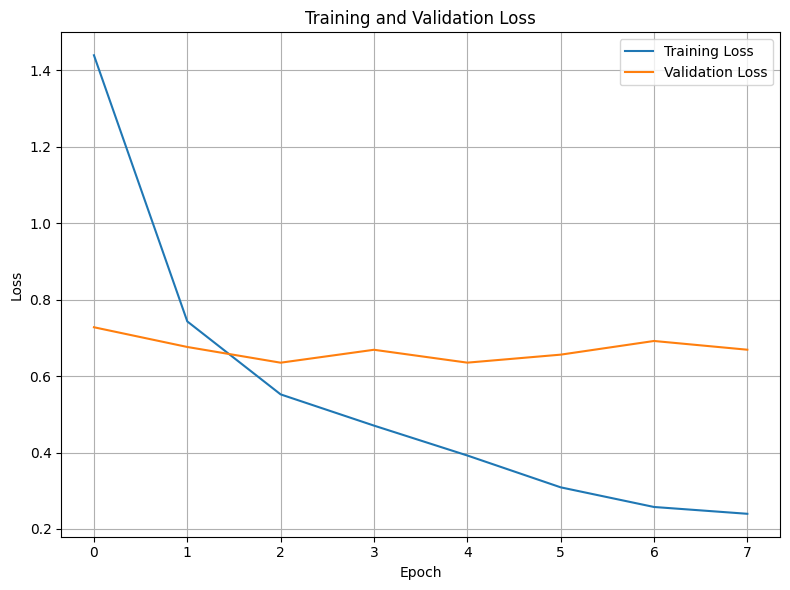

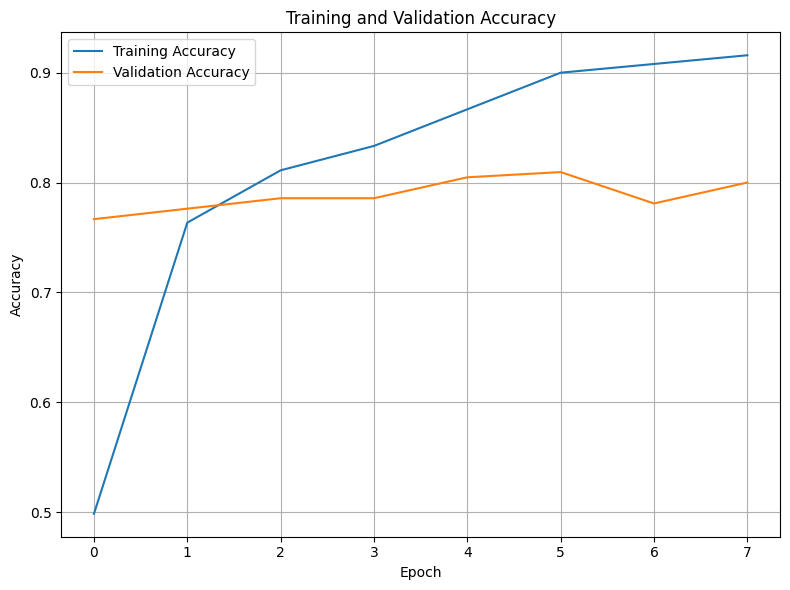

'\nshow_history(history_mobilenet_3)\nplot_history(history_mobilenet_3, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_mobilenet_4)
"""
show_history(history_mobilenet_3)
plot_history(history_mobilenet_3, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'MobileNet',
    'Paramètres': "{dropout=0.5, activation='tanh', data_aug=True, optimizer='adam', batch=32}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_mobilenet_4/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,"[0.9893617, 0.9945946, 0.9944751, 1.0, 1.0, 0....",1.994079,0.780952,0.931684,"[0.74999994, 0.6808511, 0.7368421, 0.74285716,...",1.768461,0.790476,0.935346,"[0.7457627, 0.7083333, 0.76363635, 0.7761194, ...",1.061697,0.842857,0.954881,"[0.7169811, 0.83870965, 0.84210527, 0.8484848,...",89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1.991282,0.776190,0.916948,"[0.6875, 0.71111107, 0.80701756, 0.71641797, 0...",1.828464,0.752381,0.913390,"[0.70967746, 0.6415094, 0.7346939, 0.6428572, ...",1.414793,0.752381,0.929862,"[0.53846157, 0.73846155, 0.76470584, 0.7368421...",111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,"[0.9791667, 1.0, 1.0, 1.0, 0.97727275, 1.0, 1.0]",1.095567,0.747619,0.932487,"[0.6376812, 0.71111107, 0.78260875, 0.75, 0.61...",0.911570,0.742857,0.937600,"[0.631579, 0.64000005, 0.6976744, 0.6896552, 0...",0.875823,0.738095,0.939392,"[0.5428571, 0.8000001, 0.73015875, 0.6909091, ...",22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,"[0.9473684, 0.9523809, 0.97727275, 0.94545454,...",1.117236,0.633333,0.914269,"[0.5806452, 0.45901644, 0.6363636, 0.5882353, ...",1.029917,0.647619,0.914050,"[0.5806452, 0.5333333, 0.6666667, 0.64516133, ...",0.941683,0.657143,0.928804,"[0.5714286, 0.64864874, 0.65625006, 0.5263158,...",12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,"[0.9842932, 0.9945355, 0.9944134, 1.0, 1.0, 0....",1.063808,0.723810,0.935739,"[0.5432099, 0.6666667, 0.7111111, 0.7096774, 0...",0.852322,0.728571,0.940032,"[0.5714286, 0.6818182, 0.6818182, 0.73239434, ...",0.813758,0.766667,0.946053,"[0.6451613, 0.8474576, 0.7462687, 0.7076923, 0...",20.438973
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.139652,0.985714,0.999428,"[0.97382194, 0.9836066, 0.9944134, 0.99421966,...",0.981981,0.695238,0.925882,"[0.5, 0.54999995, 0.6818182, 0.7540984, 0.7058...",0.931535,0.700000,0.927819,"[0.54545456, 0.52380955, 0.68085104, 0.6956522...",0.880991,0.676190,0.934197,"[0.43137255, 0.69696975, 0.67647064, 0.6071428...",18.402466
6,MobileNet,"{dropout=0.5, activation='tanh', data_aug=Fals...",0.231202,0.939683,0.997186,"[0.8876405, 0.9137056, 0.960452, 0.954023, 0.9...",0.960776,0.690476,0.928309,"[0.5555555, 0.5423729, 0.6530613, 0.7647059, 0...",0.941069,0.680952,0.924864,"[0.57627124, 0.49122807, 0.6666667, 0.6875, 0....",0.880369,0.666667,0.936395,"[0.54545456, 0.6666666, 0.6349206, 0.55737704,...",10.049382
7,ResNet50,"{dropout=0.2, activation='tanh', data_aug=True...",1.443429,0.463492,0.815946,"[0.37320575, 0.562212, 0.3893805, 0.48000002, ...",1.707465,0.371429,0.749815,"[0.28169015, 0.47619048, 0.38709676, 0.3564357...",1.666951,0.390476,0.746043,"[0.27118647, 0.43902442, 0.375, 0.24390244, 0....",1.655338,0.423810,0.755472,"[0.3272727, 0.5283019, 0.6666667, 0.29787233, ...",24.516449
8,MobileNet,"{dropout=0.5, activation='tanh', data_aug=True...",0.129137,0.963492,0.997996,"[0.93333334, 0.9444444, 0.9834254, 0.9444445, ...",0.669017,0.800000,0.957553,"[0.73684216, 0.6938776, 0.8076923, 0.7887324, ...",0.635050,0.785714,0.965693,"[0.6865671, 0.7234042, 0.8076923, 0.7647059, 0...",0.560259,0.838095,0.974240,"[0.7118644, 0.85714287, 0.8767123, 0.8125, 0.7...",9.466133


In [ ]:
# df_results.to_csv("/content/drive/My Drive/P6/resultats_modeles.csv", index=False)

In [ ]:
df_results = pd.read_csv('/content/drive/My Drive/P6/resultats_modeles.csv')
df_results.head()

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,[0.9893617 0.9945946 0.9944751 1. 1. ...,1.994079,0.780952,0.931684,[0.74999994 0.6808511 0.7368421 0.74285716 0...,1.768461,0.790476,0.935346,[0.7457627 0.7083333 0.76363635 0.7761194 0...,1.061697,0.842857,0.954881,[0.7169811 0.83870965 0.84210527 0.8484848 0...,89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,[1. 1. 1. 1. 1. 1. 1.],1.991282,0.776190,0.916948,[0.6875 0.71111107 0.80701756 0.71641797 0...,1.828464,0.752381,0.913390,[0.70967746 0.6415094 0.7346939 0.6428572 0...,1.414793,0.752381,0.929862,[0.53846157 0.73846155 0.76470584 0.73684216 0...,111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,[0.9791667 1. 1. 1. 0...,1.095567,0.747619,0.932487,[0.6376812 0.71111107 0.78260875 0.75 0...,0.911570,0.742857,0.937600,[0.631579 0.64000005 0.6976744 0.6896552 0...,0.875823,0.738095,0.939392,[0.5428571 0.8000001 0.73015875 0.6909091 0...,22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,[0.9473684 0.9523809 0.97727275 0.94545454 0...,1.117236,0.633333,0.914269,[0.5806452 0.45901644 0.6363636 0.5882353 0...,1.029917,0.647619,0.914050,[0.5806452 0.5333333 0.6666667 0.64516133 0...,0.941683,0.657143,0.928804,[0.5714286 0.64864874 0.65625006 0.5263158 0...,12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,[0.9842932 0.9945355 0.9944134 1. 1...,1.063808,0.723810,0.935739,[0.5432099 0.6666667 0.7111111 0.7096774 0...,0.852322,0.728571,0.940032,[0.5714286 0.6818182 0.6818182 0.73239434 0...,0.813758,0.766667,0.946053,[0.6451613 0.8474576 0.7462687 0.7076923 0...,20.438973


### Test VGG19 avec les paramètres suivants : droput=0.2, activation='tanh' et optimizer='rmsprop' avec data augmentation

In [ ]:
model_vgg19_2 = create_model_fct(model_name="VGG19", dropout_rate = 0.2, activation = "tanh", data_aug=True)

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               

In [ ]:
# Création du callback
weights_file_name10 = "./model_vgg19_2_best_weights.h5"
model_vgg19_2_save_path = os.path.join(weights_save_path, weights_file_name10)
checkpoint = ModelCheckpoint(model_vgg19_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_vgg19_2 = model_vgg19_2.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=64, epochs=50, callbacks=callbacks_list, verbose=1)
time_vgg19_2 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.6757 - accuracy: 0.3619 - auc: 0.7348 - f1_score: 0.3572 
Epoch 1: val_loss improved from inf to 1.28168, saving model to /content/drive/My Drive/P6/Models/./model_vgg19_2_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 648s 30s/step - loss: 1.6757 - accuracy: 0.3619 - auc: 0.7348 - f1_score: 0.3572 - val_loss: 1.2817 - val_accuracy: 0.5000 - val_auc: 0.8797 - val_f1_score: 0.4920
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.1522 - accuracy: 0.6222 - auc: 0.9008 - f1_score: 0.6220 
Epoch 2: val_loss improved from 1.28168 to 1.06298, saving model to /content/drive/My Drive/P6/Models/./model_vgg19_2_best_weights.h5
20/20 [==============================] - 620s 31s/step - loss: 1.1522 - accuracy: 0.6222 - auc: 0.9008 - f1_score: 0.6220 - val_loss: 1.0630 - val_accuracy: 0.6190 - val_auc: 0.9087 - val_f1_score: 0.6117
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.9858 - accuracy: 0.7032 - auc: 0.9217 - f1_score: 0.7026 
Epoch 3: val_loss improved from 1.06298 to 0.97743, saving model to /content/drive/My Drive/P6/Models/./model_vgg19_2_best_weights.h5
20/20 [==============================] - 553s 28s/step - loss: 0.9

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_vgg19_2.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_vgg19_2.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 411s 20s/step - loss: 0.3542 - accuracy: 0.8857 - auc: 0.9888 - f1_score: 0.8861
Training Accuracy   : 0.8857

7/7 [==============================] - 138s 19s/step - loss: 0.8850 - accuracy: 0.7333 - auc: 0.9406 - f1_score: 0.7306
Validation Accuracy :  0.7333


In [ ]:
# Score de l'epoch optimal

model_vgg19_2.load_weights(model_vgg19_2_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_vgg19_2.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_vgg19_2.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.7714
Test Accuracy       :  0.7952


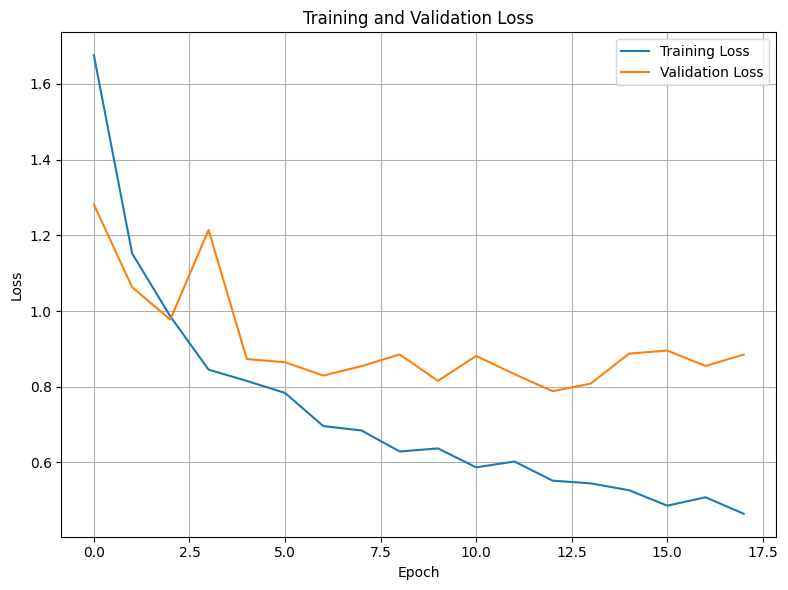

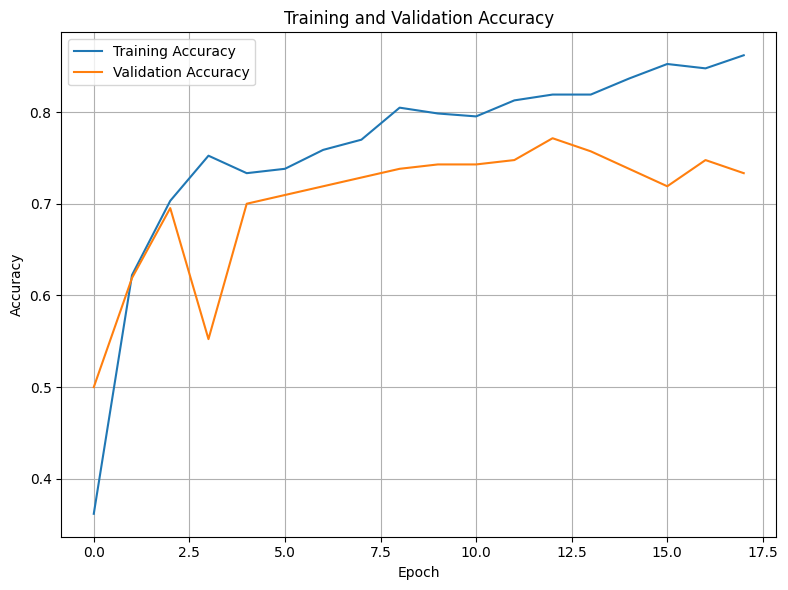

'\nshow_history(history_resnet_3)\nplot_history(history_resnet_3, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_vgg19_2)
"""
show_history(history_resnet_3)
plot_history(history_resnet_3, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'VGG19',
    'Paramètres': "{dropout=0.2, activation='tanh', data_aug=True, optimizer='rmsprop', batch=64}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_vgg19_2/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,[0.9893617 0.9945946 0.9944751 1. 1. ...,1.994079,0.780952,0.931684,[0.74999994 0.6808511 0.7368421 0.74285716 0...,1.768461,0.790476,0.935346,[0.7457627 0.7083333 0.76363635 0.7761194 0...,1.061697,0.842857,0.954881,[0.7169811 0.83870965 0.84210527 0.8484848 0...,89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,[1. 1. 1. 1. 1. 1. 1.],1.991282,0.776190,0.916948,[0.6875 0.71111107 0.80701756 0.71641797 0...,1.828464,0.752381,0.913390,[0.70967746 0.6415094 0.7346939 0.6428572 0...,1.414793,0.752381,0.929862,[0.53846157 0.73846155 0.76470584 0.73684216 0...,111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,[0.9791667 1. 1. 1. 0...,1.095567,0.747619,0.932487,[0.6376812 0.71111107 0.78260875 0.75 0...,0.911570,0.742857,0.937600,[0.631579 0.64000005 0.6976744 0.6896552 0...,0.875823,0.738095,0.939392,[0.5428571 0.8000001 0.73015875 0.6909091 0...,22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,[0.9473684 0.9523809 0.97727275 0.94545454 0...,1.117236,0.633333,0.914269,[0.5806452 0.45901644 0.6363636 0.5882353 0...,1.029917,0.647619,0.914050,[0.5806452 0.5333333 0.6666667 0.64516133 0...,0.941683,0.657143,0.928804,[0.5714286 0.64864874 0.65625006 0.5263158 0...,12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,[0.9842932 0.9945355 0.9944134 1. 1...,1.063808,0.723810,0.935739,[0.5432099 0.6666667 0.7111111 0.7096774 0...,0.852322,0.728571,0.940032,[0.5714286 0.6818182 0.6818182 0.73239434 0...,0.813758,0.766667,0.946053,[0.6451613 0.8474576 0.7462687 0.7076923 0...,20.438973
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.139652,0.985714,0.999428,[0.97382194 0.9836066 0.9944134 0.99421966 0...,0.981981,0.695238,0.925882,[0.5 0.54999995 0.6818182 0.7540984 0...,0.931535,0.700000,0.927819,[0.54545456 0.52380955 0.68085104 0.6956522 0...,0.880991,0.676190,0.934197,[0.43137255 0.69696975 0.67647064 0.60714287 0...,18.402466
6,MobileNet,"{dropout=0.5, activation='tanh', data_aug=Fals...",0.231202,0.939683,0.997186,[0.8876405 0.9137056 0.960452 0.954023 0...,0.960776,0.690476,0.928309,[0.5555555 0.5423729 0.6530613 0.7647059 0...,0.941069,0.680952,0.924864,[0.57627124 0.49122807 0.6666667 0.6875 0...,0.880369,0.666667,0.936395,[0.54545456 0.6666666 0.6349206 0.55737704 0...,10.049382
7,ResNet50,"{dropout=0.2, activation='tanh', data_aug=True...",1.443429,0.463492,0.815946,[0.37320575 0.562212 0.3893805 0.48000002 0...,1.707465,0.371429,0.749815,[0.28169015 0.47619048 0.38709676 0.3564357 0...,1.666951,0.390476,0.746043,[0.27118647 0.43902442 0.375 0.24390244 0...,1.655338,0.423810,0.755472,[0.3272727 0.5283019 0.6666667 0.29787233 0...,24.516449
8,MobileNet,"{dropout=0.5, activation='tanh', data_aug=True...",0.129137,0.963492,0.997996,[0.93333334 0.9444444 0.9834254 0.9444445 0...,0.669017,0.800000,0.957553,[0.73684216 0.6938776 0.8076923 0.7887324 0...,0.635050,0.785714,0.965693,[0.6865671 0.7234042 0.8076923 0.7647059 0.716...,0.560259,0.838095,0.974240,[0.7118644 0.85714287 0.8767123 0.8125 0...,9.466133
9,VGG19,"{dropout=0.2, activation='tanh', data_aug=True...",0.354179,0.885714,0.988825,"[0.8304094, 0.87499994, 0.9142857, 0.8140704, ...",0.884961,0.733333,0.940637,"[0.72727275, 0.72727275, 0.7346939, 0.6436782,...",0.788206,0.771429,0.948968,"[0.77966106, 0.71111107, 0.7272727, 0.6769231,...",0.643592,0.795238,0.963050,"[0.6086956, 0.852459, 0.8648648, 0.7384616, 0....",170.750073


### Test VGG19 avec les paramètres suivants : droput=0.5, activation='tanh' et optimizer='adam' avec data augmentation, batch_size = 32

In [ ]:
model_vgg19_3 = create_model_fct(model_name="VGG19", dropout_rate = 0.5, activation = "tanh", data_aug=True, optimizer='adam')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
# Création du callback
weights_file_name11 = "./model_vgg19_3_best_weights.h5"
model_vgg19_3_save_path = os.path.join(weights_save_path, weights_file_name11)
checkpoint = ModelCheckpoint(model_vgg19_3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_vgg19_3 = model_vgg19_3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=32, epochs=50, callbacks=callbacks_list, verbose=1)
time_vgg19_3 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.9480 - accuracy: 0.2444 - auc: 0.6207 - f1_score: 0.2431 
Epoch 1: val_loss improved from inf to 1.36598, saving model to /content/drive/My Drive/P6/Models/./model_vgg19_3_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 565s 28s/step - loss: 1.9480 - accuracy: 0.2444 - auc: 0.6207 - f1_score: 0.2431 - val_loss: 1.3660 - val_accuracy: 0.5619 - val_auc: 0.8645 - val_f1_score: 0.5512
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.3241 - accuracy: 0.5317 - auc: 0.8574 - f1_score: 0.5321 
Epoch 2: val_loss improved from 1.36598 to 1.07127, saving model to /content/drive/My Drive/P6/Models/./model_vgg19_3_best_weights.h5
20/20 [==============================] - 566s 28s/step - loss: 1.3241 - accuracy: 0.5317 - auc: 0.8574 - f1_score: 0.5321 - val_loss: 1.0713 - val_accuracy: 0.6286 - val_auc: 0.9114 - val_f1_score: 0.6288
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.0651 - accuracy: 0.6492 - auc: 0.9090 - f1_score: 0.6510 
Epoch 3: val_loss improved from 1.07127 to 0.94734, saving model to /content/drive/My Drive/P6/Models/./model_vgg19_3_best_weights.h5
20/20 [==============================] - 562s 28s/step - loss: 1.0

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_vgg19_3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_vgg19_3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 415s 21s/step - loss: 0.3902 - accuracy: 0.8857 - auc: 0.9871 - f1_score: 0.8849
Training Accuracy   : 0.8857

7/7 [==============================] - 139s 19s/step - loss: 0.7916 - accuracy: 0.7524 - auc: 0.9484 - f1_score: 0.7483
Validation Accuracy :  0.7524


In [ ]:
# Score de l'epoch optimal

model_vgg19_3.load_weights(model_vgg19_3_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_vgg19_3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_vgg19_3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.7476
Test Accuracy       :  0.7952


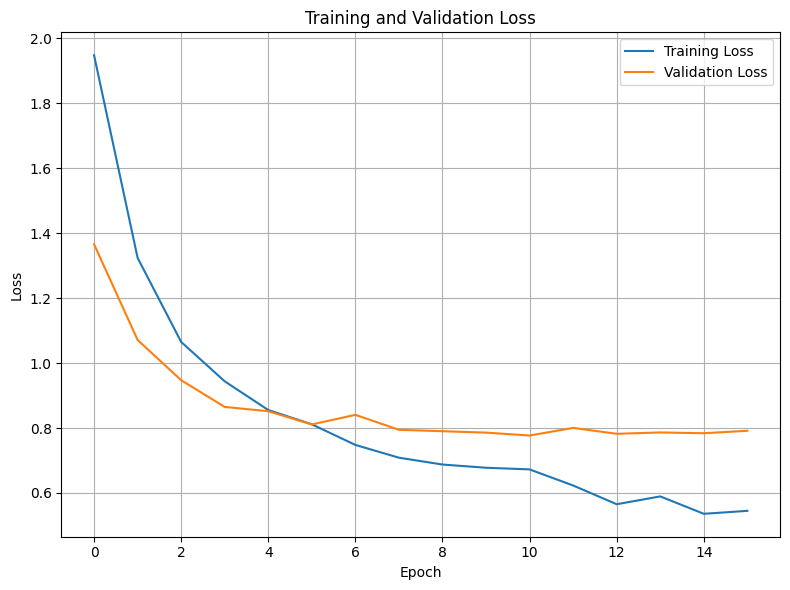

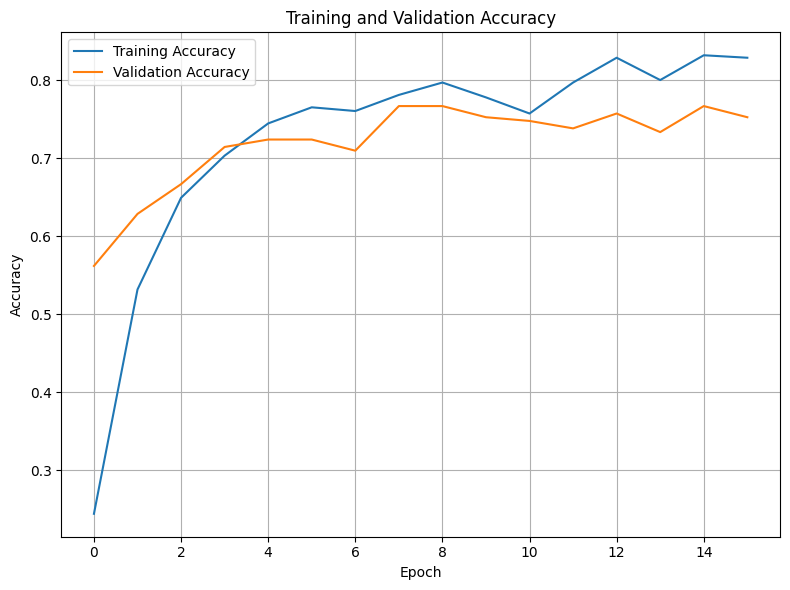

'\nshow_history(history_resnet_3)\nplot_history(history_resnet_3, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_vgg19_3)
"""
show_history(history_resnet_3)
plot_history(history_resnet_3, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'VGG19',
    'Paramètres': "{dropout=0.5, activation='tanh', data_aug=True, optimizer='adam', batch=32}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_vgg19_3/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,[0.9893617 0.9945946 0.9944751 1. 1. ...,1.994079,0.780952,0.931684,[0.74999994 0.6808511 0.7368421 0.74285716 0...,1.768461,0.790476,0.935346,[0.7457627 0.7083333 0.76363635 0.7761194 0...,1.061697,0.842857,0.954881,[0.7169811 0.83870965 0.84210527 0.8484848 0...,89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,[1. 1. 1. 1. 1. 1. 1.],1.991282,0.776190,0.916948,[0.6875 0.71111107 0.80701756 0.71641797 0...,1.828464,0.752381,0.913390,[0.70967746 0.6415094 0.7346939 0.6428572 0...,1.414793,0.752381,0.929862,[0.53846157 0.73846155 0.76470584 0.73684216 0...,111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,[0.9791667 1. 1. 1. 0...,1.095567,0.747619,0.932487,[0.6376812 0.71111107 0.78260875 0.75 0...,0.911570,0.742857,0.937600,[0.631579 0.64000005 0.6976744 0.6896552 0...,0.875823,0.738095,0.939392,[0.5428571 0.8000001 0.73015875 0.6909091 0...,22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,[0.9473684 0.9523809 0.97727275 0.94545454 0...,1.117236,0.633333,0.914269,[0.5806452 0.45901644 0.6363636 0.5882353 0...,1.029917,0.647619,0.914050,[0.5806452 0.5333333 0.6666667 0.64516133 0...,0.941683,0.657143,0.928804,[0.5714286 0.64864874 0.65625006 0.5263158 0...,12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,[0.9842932 0.9945355 0.9944134 1. 1...,1.063808,0.723810,0.935739,[0.5432099 0.6666667 0.7111111 0.7096774 0...,0.852322,0.728571,0.940032,[0.5714286 0.6818182 0.6818182 0.73239434 0...,0.813758,0.766667,0.946053,[0.6451613 0.8474576 0.7462687 0.7076923 0...,20.438973
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.139652,0.985714,0.999428,[0.97382194 0.9836066 0.9944134 0.99421966 0...,0.981981,0.695238,0.925882,[0.5 0.54999995 0.6818182 0.7540984 0...,0.931535,0.700000,0.927819,[0.54545456 0.52380955 0.68085104 0.6956522 0...,0.880991,0.676190,0.934197,[0.43137255 0.69696975 0.67647064 0.60714287 0...,18.402466
6,MobileNet,"{dropout=0.5, activation='tanh', data_aug=Fals...",0.231202,0.939683,0.997186,[0.8876405 0.9137056 0.960452 0.954023 0...,0.960776,0.690476,0.928309,[0.5555555 0.5423729 0.6530613 0.7647059 0...,0.941069,0.680952,0.924864,[0.57627124 0.49122807 0.6666667 0.6875 0...,0.880369,0.666667,0.936395,[0.54545456 0.6666666 0.6349206 0.55737704 0...,10.049382
7,ResNet50,"{dropout=0.2, activation='tanh', data_aug=True...",1.443429,0.463492,0.815946,[0.37320575 0.562212 0.3893805 0.48000002 0...,1.707465,0.371429,0.749815,[0.28169015 0.47619048 0.38709676 0.3564357 0...,1.666951,0.390476,0.746043,[0.27118647 0.43902442 0.375 0.24390244 0...,1.655338,0.423810,0.755472,[0.3272727 0.5283019 0.6666667 0.29787233 0...,24.516449
8,MobileNet,"{dropout=0.5, activation='tanh', data_aug=True...",0.129137,0.963492,0.997996,[0.93333334 0.9444444 0.9834254 0.9444445 0...,0.669017,0.800000,0.957553,[0.73684216 0.6938776 0.8076923 0.7887324 0...,0.635050,0.785714,0.965693,[0.6865671 0.7234042 0.8076923 0.7647059 0.716...,0.560259,0.838095,0.974240,[0.7118644 0.85714287 0.8767123 0.8125 0...,9.466133
9,VGG19,"{dropout=0.2, activation='tanh', data_aug=True...",0.354179,0.885714,0.988825,"[0.8304094, 0.87499994, 0.9142857, 0.8140704, ...",0.884961,0.733333,0.940637,"[0.72727275, 0.72727275, 0.7346939, 0.6436782,...",0.788206,0.771429,0.948968,"[0.77966106, 0.71111107, 0.7272727, 0.6769231,...",0.643592,0.795238,0.963050,"[0.6086956, 0.852459, 0.8648648, 0.7384616, 0....",170.750073


In [ ]:
# df_results.to_csv("/content/drive/My Drive/P6/resultats_modeles.csv", index=False)

In [ ]:
df_results = pd.read_csv("/content/drive/My Drive/P6/resultats_modeles.csv")
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,[0.9893617 0.9945946 0.9944751 1. 1. ...,1.994079,0.780952,0.931684,[0.74999994 0.6808511 0.7368421 0.74285716 0...,1.768461,0.790476,0.935346,[0.7457627 0.7083333 0.76363635 0.7761194 0...,1.061697,0.842857,0.954881,[0.7169811 0.83870965 0.84210527 0.8484848 0...,89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,[1. 1. 1. 1. 1. 1. 1.],1.991282,0.776190,0.916948,[0.6875 0.71111107 0.80701756 0.71641797 0...,1.828464,0.752381,0.913390,[0.70967746 0.6415094 0.7346939 0.6428572 0...,1.414793,0.752381,0.929862,[0.53846157 0.73846155 0.76470584 0.73684216 0...,111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,[0.9791667 1. 1. 1. 0...,1.095567,0.747619,0.932487,[0.6376812 0.71111107 0.78260875 0.75 0...,0.911570,0.742857,0.937600,[0.631579 0.64000005 0.6976744 0.6896552 0...,0.875823,0.738095,0.939392,[0.5428571 0.8000001 0.73015875 0.6909091 0...,22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,[0.9473684 0.9523809 0.97727275 0.94545454 0...,1.117236,0.633333,0.914269,[0.5806452 0.45901644 0.6363636 0.5882353 0...,1.029917,0.647619,0.914050,[0.5806452 0.5333333 0.6666667 0.64516133 0...,0.941683,0.657143,0.928804,[0.5714286 0.64864874 0.65625006 0.5263158 0...,12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,[0.9842932 0.9945355 0.9944134 1. 1...,1.063808,0.723810,0.935739,[0.5432099 0.6666667 0.7111111 0.7096774 0...,0.852322,0.728571,0.940032,[0.5714286 0.6818182 0.6818182 0.73239434 0...,0.813758,0.766667,0.946053,[0.6451613 0.8474576 0.7462687 0.7076923 0...,20.438973
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.139652,0.985714,0.999428,[0.97382194 0.9836066 0.9944134 0.99421966 0...,0.981981,0.695238,0.925882,[0.5 0.54999995 0.6818182 0.7540984 0...,0.931535,0.700000,0.927819,[0.54545456 0.52380955 0.68085104 0.6956522 0...,0.880991,0.676190,0.934197,[0.43137255 0.69696975 0.67647064 0.60714287 0...,18.402466
6,MobileNet,"{dropout=0.5, activation='tanh', data_aug=Fals...",0.231202,0.939683,0.997186,[0.8876405 0.9137056 0.960452 0.954023 0...,0.960776,0.690476,0.928309,[0.5555555 0.5423729 0.6530613 0.7647059 0...,0.941069,0.680952,0.924864,[0.57627124 0.49122807 0.6666667 0.6875 0...,0.880369,0.666667,0.936395,[0.54545456 0.6666666 0.6349206 0.55737704 0...,10.049382
7,ResNet50,"{dropout=0.2, activation='tanh', data_aug=True...",1.443429,0.463492,0.815946,[0.37320575 0.562212 0.3893805 0.48000002 0...,1.707465,0.371429,0.749815,[0.28169015 0.47619048 0.38709676 0.3564357 0...,1.666951,0.390476,0.746043,[0.27118647 0.43902442 0.375 0.24390244 0...,1.655338,0.423810,0.755472,[0.3272727 0.5283019 0.6666667 0.29787233 0...,24.516449
8,MobileNet,"{dropout=0.5, activation='tanh', data_aug=True...",0.129137,0.963492,0.997996,[0.93333334 0.9444444 0.9834254 0.9444445 0...,0.669017,0.800000,0.957553,[0.73684216 0.6938776 0.8076923 0.7887324 0...,0.635050,0.785714,0.965693,[0.6865671 0.7234042 0.8076923 0.7647059 0.716...,0.560259,0.838095,0.974240,[0.7118644 0.85714287 0.8767123 0.8125 0...,9.466133
9,VGG19,"{dropout=0.2, activation='tanh', data_aug=True...",0.354179,0.885714,0.988825,[0.8304094 0.87499994 0.9142857 0.8140704 0...,0.884961,0.733333,0.940637,[0.72727275 0.72727275 0.7346939 0.6436782 0...,0.788206,0.771429,0.948968,[0.77966106 0.71111107 0.7272727 0.6769231 0...,0.643592,0.795238,0.963050,[0.6086956 0.852459 0.8648648 0.7384616 0...,170.750073


### Test VGG16 avec les paramètres suivants : droput=0.3, activation='relu' et optimizer='rmsprop' avec data augmentation, batch_size = 64

In [ ]:
model_vgg16_2 = create_model_fct(model_name="VGG16", dropout_rate = 0.3, activation = "relu", data_aug=True, optimizer='rmsprop')

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               

In [ ]:
# Création du callback
weights_file_name12 = "./model_vgg16_2_best_weights.h5"
model_vgg16_2_save_path = os.path.join(weights_save_path, weights_file_name12)
checkpoint = ModelCheckpoint(model_vgg16_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
# Entraînement du modèle :
time_0 = time.time()
history_vgg16_2 = model_vgg16_2.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=32, epochs=50, callbacks=callbacks_list, verbose=1)
time_vgg16_2 = time.time() - time_0

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.6686 - accuracy: 0.3905 - auc: 0.7366 - f1_score: 0.3897 
Epoch 1: val_loss improved from inf to 1.26476, saving model to /content/drive/My Drive/P6/Models/./model_vgg16_2_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 689s 31s/step - loss: 1.6686 - accuracy: 0.3905 - auc: 0.7366 - f1_score: 0.3897 - val_loss: 1.2648 - val_accuracy: 0.5905 - val_auc: 0.9126 - val_f1_score: 0.5725
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.2314 - accuracy: 0.6063 - auc: 0.8937 - f1_score: 0.6055 
Epoch 2: val_loss improved from 1.26476 to 1.05734, saving model to /content/drive/My Drive/P6/Models/./model_vgg16_2_best_weights.h5
20/20 [==============================] - 531s 27s/step - loss: 1.2314 - accuracy: 0.6063 - auc: 0.8937 - f1_score: 0.6055 - val_loss: 1.0573 - val_accuracy: 0.6476 - val_auc: 0.9258 - val_f1_score: 0.6330
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.0371 - accuracy: 0.6825 - auc: 0.9191 - f1_score: 0.6814 
Epoch 3: val_loss improved from 1.05734 to 0.99826, saving model to /content/drive/My Drive/P6/Models/./model_vgg16_2_best_weights.h5
20/20 [==============================] - 532s 27s/step - loss: 1.0

In [ ]:
# Score du dernier epoch

train_loss_last, train_accuracy_last, train_auc_last, train_f1_score_last = model_vgg16_2.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(train_accuracy_last))
print()
val_loss_last, val_accuracy_last, val_auc_last, val_f1_score_last = model_vgg16_2.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_last))

20/20 [==============================] - 387s 19s/step - loss: 0.3589 - accuracy: 0.8905 - auc: 0.9886 - f1_score: 0.8902
Training Accuracy   : 0.8905

7/7 [==============================] - 131s 18s/step - loss: 0.7389 - accuracy: 0.7905 - auc: 0.9522 - f1_score: 0.7887
Validation Accuracy :  0.7905


In [ ]:
# Score de l'epoch optimal

model_vgg16_2.load_weights(model_vgg16_2_save_path)

val_loss_opt, val_accuracy_opt, val_auc_opt, val_f1_score_opt = model_vgg16_2.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(val_accuracy_opt))

test_loss_opt, test_accuracy_opt, test_auc_opt, test_f1_score_opt = model_vgg16_2.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(test_accuracy_opt))

Validation Accuracy :  0.7810
Test Accuracy       :  0.7905


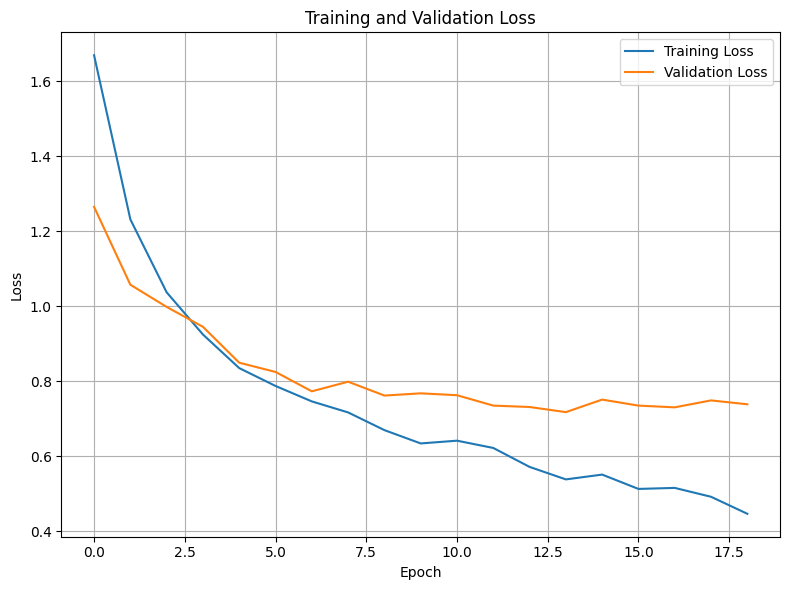

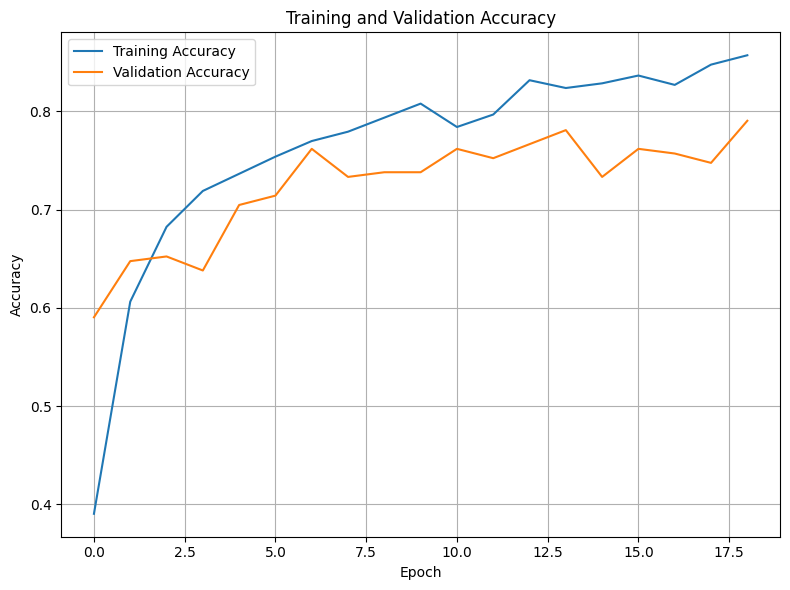

'\nshow_history(history_resnet_3)\nplot_history(history_resnet_3, path="standard.png")\nplt.close()\n'

In [ ]:
plot_loss_accuracy(history_vgg16_2)
"""
show_history(history_resnet_3)
plot_history(history_resnet_3, path="standard.png")
plt.close()
"""

In [ ]:
# Création du dictionnaire de données
data = {
    'Nom du modèle': 'VGG16',
    'Paramètres': "{dropout=0.3, activation='relu', data_aug=True, optimizer='rmsprop', batch=64}",
    'train_loss_last': train_loss_last,
    'train_accuracy_last': train_accuracy_last,
    'train_auc_last': train_auc_last,
    'train_f1_score_last': train_f1_score_last,
    'val_loss_last': val_loss_last,
    'val_accuracy_last': val_accuracy_last,
    'val_auc_last': val_auc_last,
    'val_f1_score_last': val_f1_score_last,
    'val_loss_opt': val_loss_opt,
    'val_accuracy_opt': val_accuracy_opt,
    'val_auc_opt': val_auc_opt,
    'val_f1_score_opt': val_f1_score_opt,
    'test_loss_opt': test_loss_opt,
    'test_accuracy_opt': test_accuracy_opt,
    'test_auc_opt': test_auc_opt,
    'test_f1_score_opt': test_f1_score_opt,
    'Temps d\'entraînement (mn)': time_vgg16_2/60
}

# Création du DataFrame à partir du dictionnaire
df_tmp = pd.DataFrame([data])
df_results = pd.concat([df_results, df_tmp], axis = 0, ignore_index=True)
display(df_results)

,Nom du modèle,Paramètres,train_loss_last,train_accuracy_last,train_auc_last,train_f1_score_last,val_loss_last,val_accuracy_last,val_auc_last,val_f1_score_last,val_loss_opt,val_accuracy_opt,val_auc_opt,val_f1_score_opt,test_loss_opt,test_accuracy_opt,test_auc_opt,test_f1_score_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.008328,0.995238,0.999996,[0.9893617 0.9945946 0.9944751 1. 1. ...,1.994079,0.780952,0.931684,[0.74999994 0.6808511 0.7368421 0.74285716 0...,1.768461,0.790476,0.935346,[0.7457627 0.7083333 0.76363635 0.7761194 0...,1.061697,0.842857,0.954881,[0.7169811 0.83870965 0.84210527 0.8484848 0...,89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",0.003346,1.000000,1.000000,[1. 1. 1. 1. 1. 1. 1.],1.991282,0.776190,0.916948,[0.6875 0.71111107 0.80701756 0.71641797 0...,1.828464,0.752381,0.913390,[0.70967746 0.6415094 0.7346939 0.6428572 0...,1.414793,0.752381,0.929862,[0.53846157 0.73846155 0.76470584 0.73684216 0...,111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.035798,0.993651,0.999875,[0.9791667 1. 1. 1. 0...,1.095567,0.747619,0.932487,[0.6376812 0.71111107 0.78260875 0.75 0...,0.911570,0.742857,0.937600,[0.631579 0.64000005 0.6976744 0.6896552 0...,0.875823,0.738095,0.939392,[0.5428571 0.8000001 0.73015875 0.6909091 0...,22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.168444,0.958730,0.998547,[0.9473684 0.9523809 0.97727275 0.94545454 0...,1.117236,0.633333,0.914269,[0.5806452 0.45901644 0.6363636 0.5882353 0...,1.029917,0.647619,0.914050,[0.5806452 0.5333333 0.6666667 0.64516133 0...,0.941683,0.657143,0.928804,[0.5714286 0.64864874 0.65625006 0.5263158 0...,12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.044862,0.995238,0.999934,[0.9842932 0.9945355 0.9944134 1. 1...,1.063808,0.723810,0.935739,[0.5432099 0.6666667 0.7111111 0.7096774 0...,0.852322,0.728571,0.940032,[0.5714286 0.6818182 0.6818182 0.73239434 0...,0.813758,0.766667,0.946053,[0.6451613 0.8474576 0.7462687 0.7076923 0...,20.438973
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.139652,0.985714,0.999428,[0.97382194 0.9836066 0.9944134 0.99421966 0...,0.981981,0.695238,0.925882,[0.5 0.54999995 0.6818182 0.7540984 0...,0.931535,0.700000,0.927819,[0.54545456 0.52380955 0.68085104 0.6956522 0...,0.880991,0.676190,0.934197,[0.43137255 0.69696975 0.67647064 0.60714287 0...,18.402466
6,MobileNet,"{dropout=0.5, activation='tanh', data_aug=Fals...",0.231202,0.939683,0.997186,[0.8876405 0.9137056 0.960452 0.954023 0...,0.960776,0.690476,0.928309,[0.5555555 0.5423729 0.6530613 0.7647059 0...,0.941069,0.680952,0.924864,[0.57627124 0.49122807 0.6666667 0.6875 0...,0.880369,0.666667,0.936395,[0.54545456 0.6666666 0.6349206 0.55737704 0...,10.049382
7,ResNet50,"{dropout=0.2, activation='tanh', data_aug=True...",1.443429,0.463492,0.815946,[0.37320575 0.562212 0.3893805 0.48000002 0...,1.707465,0.371429,0.749815,[0.28169015 0.47619048 0.38709676 0.3564357 0...,1.666951,0.390476,0.746043,[0.27118647 0.43902442 0.375 0.24390244 0...,1.655338,0.423810,0.755472,[0.3272727 0.5283019 0.6666667 0.29787233 0...,24.516449
8,MobileNet,"{dropout=0.5, activation='tanh', data_aug=True...",0.129137,0.963492,0.997996,[0.93333334 0.9444444 0.9834254 0.9444445 0...,0.669017,0.800000,0.957553,[0.73684216 0.6938776 0.8076923 0.7887324 0...,0.635050,0.785714,0.965693,[0.6865671 0.7234042 0.8076923 0.7647059 0.716...,0.560259,0.838095,0.974240,[0.7118644 0.85714287 0.8767123 0.8125 0...,9.466133
9,VGG19,"{dropout=0.2, activation='tanh', data_aug=True...",0.354179,0.885714,0.988825,[0.8304094 0.87499994 0.9142857 0.8140704 0...,0.884961,0.733333,0.940637,[0.72727275 0.72727275 0.7346939 0.6436782 0...,0.788206,0.771429,0.948968,[0.77966106 0.71111107 0.7272727 0.6769231 0...,0.643592,0.795238,0.963050,[0.6086956 0.852459 0.8648648 0.7384616 0...,170.750073


In [ ]:
df_results.to_csv("/content/drive/My Drive/P6/resultats_modeles.csv", index=False)

## Analyse des résultats

In [ ]:
df_results = pd.read_csv("/content/drive/My Drive/P6/resultats_modeles.csv")

In [ ]:
df_without_aug = df_results.head(7)
df_aug = df_results.tail()

In [ ]:
df_without_aug_results = df_without_aug[["Nom du modèle", "Paramètres", "train_accuracy_last", "val_accuracy_last", "val_accuracy_opt", "Temps d'entraînement (mn)"]]

In [ ]:
display(df_without_aug_results)

,Nom du modèle,Paramètres,train_accuracy_last,val_accuracy_last,val_accuracy_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.995238,0.780952,0.790476,89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",1.000000,0.776190,0.752381,111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.993651,0.747619,0.742857,22.885804
3,MobileNet,"{dropout=0.3, activation='relu', data_aug=Fals...",0.958730,0.633333,0.647619,12.106025
4,ResNet50,"{dropout=0.2, activation='tanh', data_aug=Fals...",0.995238,0.723810,0.728571,20.438973
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.985714,0.695238,0.700000,18.402466
6,MobileNet,"{dropout=0.5, activation='tanh', data_aug=Fals...",0.939683,0.690476,0.680952,10.049382


In [ ]:
modele_a_supp = [3, 4, 6]
df_without_aug_results = df_without_aug_results.drop(modele_a_supp)
df_without_aug_results

,Nom du modèle,Paramètres,train_accuracy_last,val_accuracy_last,val_accuracy_opt,Temps d'entraînement (mn)
0,VGG16,"{dropout=0.3, activation='relu', data_aug=Fals...",0.995238,0.780952,0.790476,89.088674
1,VGG19,"{dropout=0.3, activation='relu', data_aug=Fals...",1.000000,0.776190,0.752381,111.875271
2,ResNet50,"{dropout=0.3, activation='relu', data_aug=Fals...",0.993651,0.747619,0.742857,22.885804
5,MobileNet,"{dropout=0.5, activation='relu', data_aug=Fals...",0.985714,0.695238,0.700000,18.402466


In [ ]:
df_without_aug_results.set_index("Nom du modèle", inplace=True)

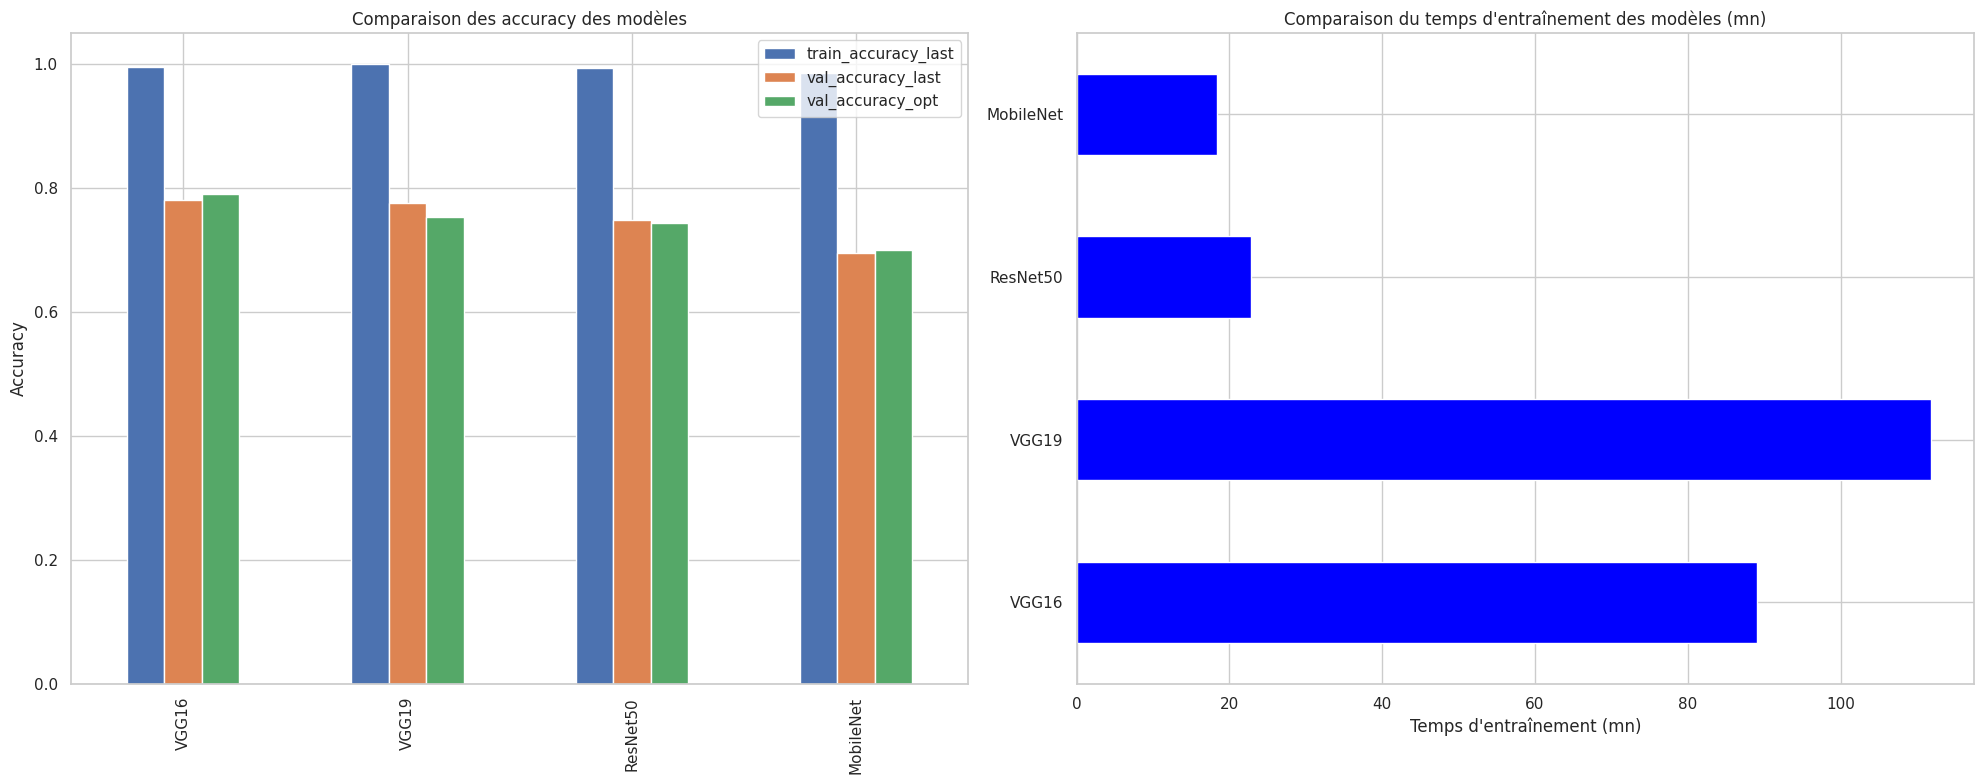

In [ ]:
# On trace les graphiques
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Graphique pour les précisions (accuracy)
df_without_aug_results[['train_accuracy_last', 'val_accuracy_last', 'val_accuracy_opt']].plot(kind='bar', ax=axs[0])
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Comparaison des accuracy des modèles')
axs[0].set_xlabel('')

# Graphique pour le temps d'entraînement
df_without_aug_results["Temps d'entraînement (mn)"].plot(kind='barh', ax=axs[1], color='blue')
axs[1].set_xlabel("Temps d'entraînement (mn)")
axs[1].set_title('Comparaison du temps d\'entraînement des modèles (mn)')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
df_aug_results = df_aug[["Nom du modèle", "Paramètres", "train_accuracy_last", "val_accuracy_last", "val_accuracy_opt", "Temps d'entraînement (mn)"]]

In [ ]:
df_aug_results.set_index("Nom du modèle", inplace=True)

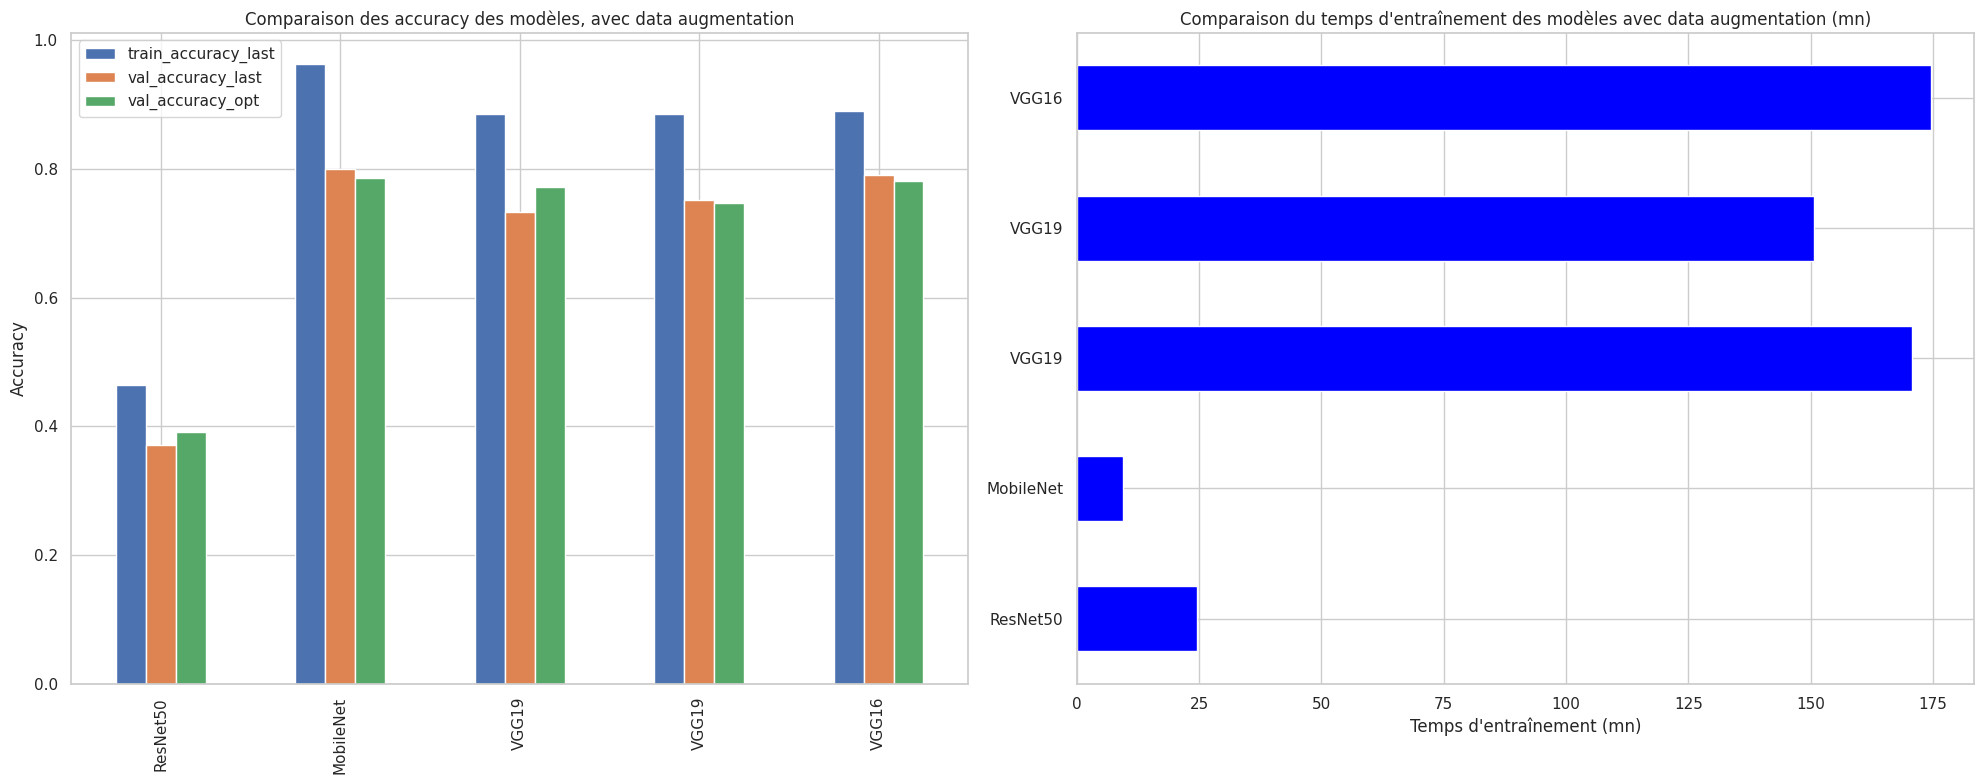

In [ ]:
# On trace les graphiques
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Graphique pour les précisions (accuracy)
df_aug_results[['train_accuracy_last', 'val_accuracy_last', 'val_accuracy_opt']].plot(kind='bar', ax=axs[0])
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Comparaison des accuracy des modèles, avec data augmentation')
axs[0].set_xlabel('')

# Graphique pour le temps d'entraînement
df_aug_results["Temps d'entraînement (mn)"].plot(kind='barh', ax=axs[1], color='blue')
axs[1].set_xlabel("Temps d'entraînement (mn)")
axs[1].set_title('Comparaison du temps d\'entraînement des modèles avec data augmentation (mn)')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
df_aug_results2 = df_aug_results.drop(df_aug_results.index[0])
df_aug_results2

,Paramètres,train_accuracy_last,val_accuracy_last,val_accuracy_opt,Temps d'entraînement (mn)
Nom du modèle,,,,,
MobileNet,"{dropout=0.5, activation='tanh', data_aug=True...",0.963492,0.800000,0.785714,9.466133
VGG19,"{dropout=0.2, activation='tanh', data_aug=True...",0.885714,0.733333,0.771429,170.750073
VGG19,"{dropout=0.5, activation='tanh', data_aug=True...",0.885714,0.752381,0.747619,150.745229
VGG16,"{dropout=0.3, activation='relu', data_aug=True...",0.890476,0.790476,0.780952,174.607214


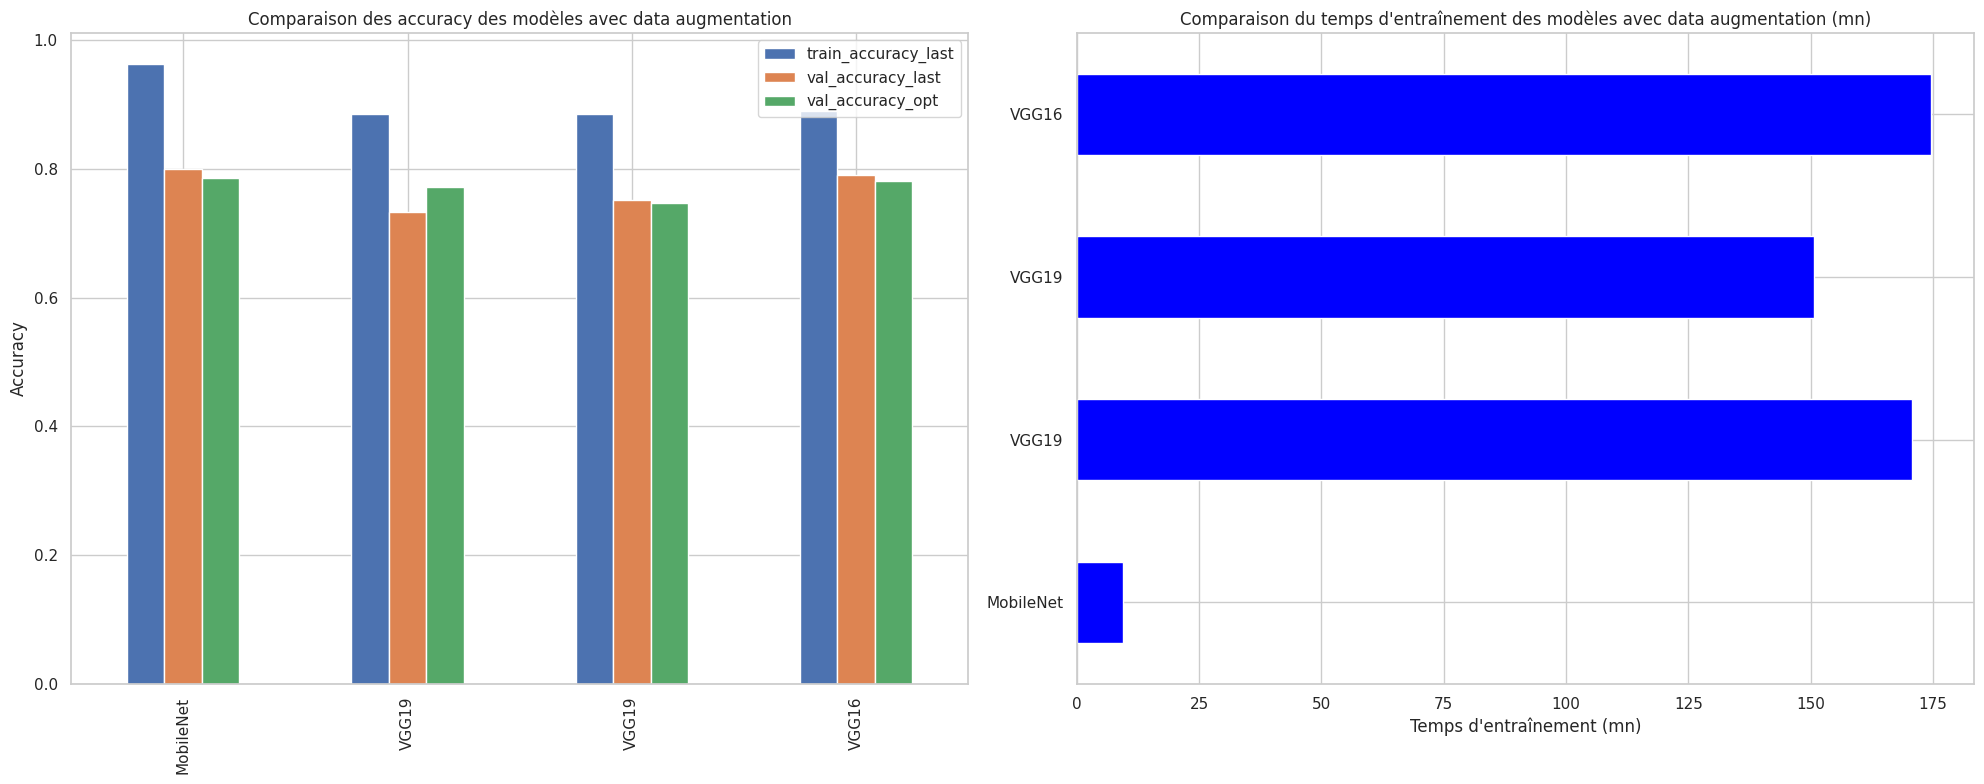

In [ ]:
# On trace les graphiques
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Graphique pour les précisions (accuracy)
df_aug_results2[['train_accuracy_last', 'val_accuracy_last', 'val_accuracy_opt']].plot(kind='bar', ax=axs[0])
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Comparaison des accuracy des modèles avec data augmentation')
axs[0].set_xlabel('')

# Graphique pour le temps d'entraînement
df_aug_results2["Temps d'entraînement (mn)"].plot(kind='barh', ax=axs[1], color='blue')
axs[1].set_xlabel("Temps d'entraînement (mn)")
axs[1].set_title('Comparaison du temps d\'entraînement des modèles avec data augmentation (mn)')
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()